In [2]:
import os

os.chdir("../")
%pwd


'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram'

In [3]:
import pandas as pd
import ast
from pathlib import Path
import numpy as np

In [3]:
raw_data_path = Path(
    "artifacts/data_ingestion/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
)
data_path = os.path.join(os.getcwd(), raw_data_path)
# data_path = os.getcwd()
data_path

'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram\\artifacts\\data_ingestion\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

### Using data generator form pytorch

In [4]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [7]:
### PTB-XL data loading code adapted from https://physionet.org/content/ptb-xl/1.0.0/ ###

import wfdb
import random
from torch.utils.data import Dataset
import torch

PTBXL_PATH = data_path


class PTBXL(Dataset):
    def __init__(self, x, y):
        super(PTBXL, self).__init__()

        # Downsample to 250 Hz and chop off last 4 samples to get 2496 overall
        if x.shape[1] != 2496 and x.shape[1] == 5000:
            # pad
            x = x[:, ::2, :]
            x = x[:, :-4]
        self.x = np.transpose(x, (0, 2, 1)).astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        sample = (x, y)
        return sample


seed = 0
train_samp = 1000
task = "all"
batch_size = 128


class PTBXLWrapper(object):
    def __init__(self, batch_size, num_workers=0):
        self.batch_size = batch_size
        self.num_workers = num_workers

    def get_data_loaders(self):
        # def load_raw_data(df, sampling_rate, path):
        #     print(df.head(1))
        #     if sampling_rate == 100:
        #         data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
        #     else:
        #         data = [wfdb.rdsamp(os.path.join(path ,f)) for f in df.filename_hr]
        #     data = np.array([signal for signal, meta in data])
        #     return data

        # idxd = {"NORM": 0, "MI": 1, "STTC": 2, "CD": 3, "HYP": 4}

        # def aggregate_diagnostic(y_dic):
        #     tmp = np.zeros(5)
        #     for key in y_dic.keys():
        #         if key in agg_df.index:
        #             cls = agg_df.loc[key].diagnostic_class
        #             tmp[idxd[cls]] = 1
        #     return tmp

        path = PTBXL_PATH
        sampling_rate = 500

        # load and convert annotation data
        Y = pd.read_csv(os.path.join(path, "ptbxl_database.csv"), index_col="ecg_id")
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sampling_rate, path)

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv(os.path.join(path, "scp_statements.csv"), index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        # Apply diagnostic superclass
        Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)
        print(Y.shape)
        # Split data into train and test
        test_fold = 10
        # Train
        X_train = X[np.where(Y.strat_fold != test_fold)]
        y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
        y_train = np.stack(y_train, axis=0)

        # Test
        X_test = X[np.where(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
        y_test = np.stack(y_test, axis=0)

        # Normalisation: follow PTB-XL demo code. Do zero mean, unit var normalisation across all leads, timesteps, and patients
        meansig = np.mean(X_train.reshape(-1))
        stdsig = np.std(X_train.reshape(-1))
        X_train = (X_train - meansig) / stdsig
        X_test = (X_test - meansig) / stdsig

        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        rng = np.random.RandomState(seed)
        idxs = np.arange(len(y_train))
        rng.shuffle(idxs)

        train_samp = int(0.8 * train_samp)
        val_samp = train_samp - train_samp

        train_idxs = idxs[:train_samp]
        val_idxs = idxs[train_samp : train_samp + val_samp]

        if task != "all":
            task_idx = idxd[task]
            prevalence = np.mean(y_train[:, task_idx])
            self.weights = []
            for i in y_train[train_idxs][:, task_idx]:
                if i == 1:
                    self.weights.append(1 - prevalence)
                else:
                    self.weights.append(prevalence)

            ft_train = PTBXL(X_train[train_idxs], y_train[train_idxs][:, task_idx])
            ft_val = PTBXL(X_train[val_idxs], y_train[val_idxs][:, task_idx])
            ft_test = PTBXL(X_test, y_test[:, task_idx])

        else:
            ft_train = PTBXL(X_train[train_idxs], y_train[train_idxs])
            ft_val = PTBXL(X_train[val_idxs], y_train[val_idxs])
            ft_test = PTBXL(X_test, y_test)

        train_loader = torch.utils.data.DataLoader(
            dataset=ft_train, batch_size=batch_size, shuffle=True, num_workers=0
        )
        # val_loader = torch.utils.data.DataLoader(
        #     dataset=ft_val, batch_size=batch_size, shuffle=True, num_workers=0
        # )
        test_loader = torch.utils.data.DataLoader(
            dataset=ft_test, batch_size=batch_size, shuffle=True, num_workers=0
        )

        return train_loader, val_loader, test_loader

In [22]:
# from ptbxl_dataset import PTBXLWrapper
dataset_wrapper = PTBXLWrapper(128)
train_dataloader, val_dataloader, test_dataloader = dataset_wrapper.get_data_loaders()

        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   

       validated_by_human baseline_drift static_noise burst_noise  \
ecg_id                                                              
1                    True            NaN    , I-V1,           NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
1                       NaN          NaN        NaN           3   

                      filename_lr                filename_hr  
ecg_id                                                        
1       records

: 

### Data collection

In [4]:
agg_df = pd.read_csv(os.path.join(data_path, "scp_statements.csv"), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
agg_df.head(2)

description  diagnostic  form  rhythm  \
NDT   non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_         non-specific ST changes         1.0   1.0     NaN   

     diagnostic_class diagnostic_subclass  \
NDT              STTC                STTC   
NST_             STTC                NST_   

                                     Statement Category  \
NDT                   other ST-T descriptive statements   
NST_  Basic roots for coding ST-T changes and abnorm...   

       SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT   non-diagnostic T abnormalities       NaN                   NaN   
NST_         non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   

     CDISC Code DICOM Code  
NDT         NaN        NaN  
NST_        NaN        NaN

In [5]:
files = pd.read_csv(os.path.join(data_path, "ptbxl_database.csv"), index_col="ecg_id")
os.path.join(data_path, files["filename_lr"].iloc[0])

'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram\\artifacts\\data_ingestion\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\\records100/00000/00001_lr'

In [8]:
# def aggregate -- commented
# # data_path = os.getcwd()


# Y = pd.read_csv(os.path.join(data_path,'ptbxl_database.csv'), index_col='ecg_id')


# Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# def aggregate_diagnostic(y_dic):


#     # print(y_dic)j\


#     tmp = []


#     for key in y_dic.keys():


#         # print(f"the key is {key}")


#         if key in agg_df.index:


#             tmp.append(agg_df.loc[key].diagnostic_class)


#             # print(f"value append to the tmp {list(set(agg_df.loc[key].diagnostic_class))}")


#     return list(set(tmp))


# Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


# Y.shape

In [6]:
# # Createing Y func
import pandas as pd


# from heartDiseaseClassification import logger


def load_raw_data(df, sampling_rate, path):
    # if sampling_rate == 100:

    #     data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]

    # else:

    #     data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]

    # data = np.array([signal for signal, meta in data])

    # return data

    data = []

    if sampling_rate == 100:
        # data = df['filename_lr'].apply(lambda x:wfdb.rdsamp(os.path.join(path,x)))

        # data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]

        for filename in df["filename_lr"]:
            try:
                sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                data.append(sample)

            except Exception as e:
                print(e)

                # logger.error(f"error processing file {filename}: {e}")

    else:
        for filename in df["filename_hr"]:
            try:
                sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                data.append(sample)

            except Exception as e:
                print(e)

                # logger.error(f"error processing file {filename}: {e}")

    # logger.info(f"ecg data loaded!! converting to numpy.")

    data = np.array([signal for signal, meta in data])

    return data


# path = data_path


# path = 'D:\college_work\4th year\Sem7th\Project\major-project\dataset\ecg-dataset\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

sampling_rate = 100


# load and convert annotation data


Y = pd.read_csv(os.path.join(data_path, "ptbxl_database.csv"), index_col="ecg_id")


Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load raw signal data


# X = load_raw_data(Y, sampling_rate, data_path)


print(Y.shape)


# print(X.shape)


# # Load scp_statements.csv for diagnostic aggregation


agg_df = pd.read_csv(os.path.join(data_path, "scp_statements.csv"), index_col=0)


agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []

    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)

    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)


# print(Y)


# # Split data into train and test


# test_fold = 10


# # Train


# X_train = X[np.where(Y.strat_fold != test_fold)]


# y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass


# # Test


# X_test = X[np.where(Y.strat_fold == test_fold)]


# y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


# print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")


# print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")

(21799, 27)


In [7]:
X = np.load("artifacts/data_transformation/wfdb_ECG_data/X-numpy_ecg.npy")
X.shape

(21799, 1000, 12)

In [8]:
# XY_train masking
mask = Y["diagnostic_superclass"].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask]
Y_filtered["diagnostic_superclass"] = Y_filtered["diagnostic_superclass"].apply(
    lambda x: x[0]
)
dic = {"NORM": 0, "MI": 1, "STTC": 2, "CD": 3, "HYP": 4}
Y_filtered["diagnostic_superclass"] = Y_filtered["diagnostic_superclass"].map(dic)
Y_filtered_np = np.array(Y_filtered["diagnostic_superclass"])
X_filtered = X[mask]
print(f"new X data size after masking {X_filtered.shape}")
# X_reshape = np.reshape(X_filtered,(16244*1000,12))
test_fold = 10
val_fold = 9
# print(f"new X data size after Reshaping {X_reshape.shape}")
# # Train
X_train = X_filtered[
    np.where((Y_filtered.strat_fold != test_fold) & (Y_filtered.strat_fold != val_fold))
]
y_train = Y_filtered_np[
    ((Y_filtered.strat_fold != test_fold) & (Y_filtered.strat_fold != val_fold))
]
# Test
X_test = X_filtered[np.where(Y_filtered.strat_fold == test_fold)]
y_test = Y_filtered_np[(Y_filtered.strat_fold == test_fold)]
# Valdiation
X_val = X_filtered[np.where((Y_filtered.strat_fold == val_fold))]
y_val = Y_filtered_np[(Y_filtered.strat_fold == val_fold)]
# ## Standerdization
# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler()
# X_scaler.fit(X_train)
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)
# X_val = X_scaler.transform(X_val)
print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

C:\Users\Ukant\AppData\Local\Temp\ipykernel_13664\2619707832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_filtered["diagnostic_superclass"] = Y_filtered["diagnostic_superclass"].apply(
C:\Users\Ukant\AppData\Local\Temp\ipykernel_13664\2619707832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_filtered["diagnostic_superclass"] = Y_filtered["diagnostic_superclass"].map(dic)


new X data size after masking (16244, 1000, 12)
y_train shape (12957,), X_train shape (12957, 1000, 12)
y_test shape (1650,), X_test shape (1650, 1000, 12)
y_val shape (1637,), X_val shape (1637, 1000, 12)


In [13]:
X_train.shape, y_train.shape

((12957, 1000, 12), (12957,))

In [23]:
X_train.shape, y_train.shape

((15957, 1000, 12), (15957,))

### Data Loading

In [4]:
import numpy as np
X_train_raw  = np.load("artifacts/data_transformation/data_split/X_train.npy",)
X_test_raw  = np.load("artifacts/data_transformation/data_split/X_test.npy",)
X_val_raw  = np.load("artifacts/data_transformation/data_split/X_val.npy",)
y_train_raw  = np.load("artifacts/data_transformation/data_split/y_train.npy",)
y_test_raw  = np.load("artifacts/data_transformation/data_split/y_test.npy",)
y_val_raw  = np.load("artifacts/data_transformation/data_split/y_val.npy",)

print(f"y_train shape {y_train_raw.shape}, X_train shape {X_train_raw.shape}")
print(f"y_test shape {y_test_raw.shape}, X_test shape {X_test_raw.shape}")
print(f"y_val shape {y_val_raw.shape}, X_val shape {X_val_raw.shape}")
np.unique(y_train_raw,return_counts=True)

y_train shape (12957,), X_train shape (12957, 1000, 12)
y_test shape (1650,), X_test shape (1650, 1000, 12)
y_val shape (1637,), X_val shape (1637, 1000, 12)


(array([0, 1, 2, 3, 4], dtype=int64),
 array([7243, 2043, 1903, 1353,  415], dtype=int64))

VIsualization of classes 

C:\Users\Ukant\AppData\Local\Temp\ipykernel_14132\3186397599.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")
C:\Users\Ukant\AppData\Local\Temp\ipykernel_14132\3186397599.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")


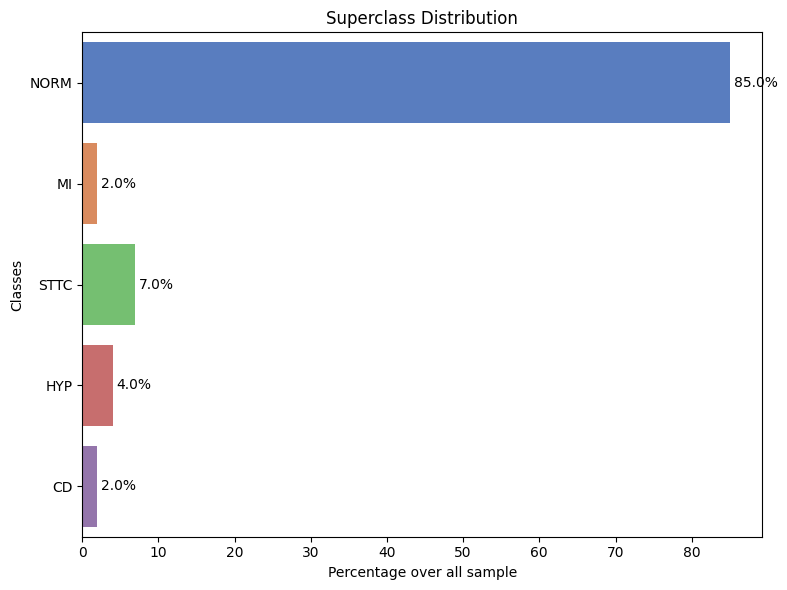

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

class_counts = np.bincount(y_train)
total_samples = y_train.shape[0]
class_percentages = (class_counts / total_samples) * 100
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")
plt.xlabel('Percentage over all sample')
plt.ylabel('Classes')
plt.title('Superclass Distribution')

for i, v in enumerate(class_percentages):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center', ha='left')

plt.tight_layout()
plt.show()

In [25]:
import numpy as np
X_train_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/X_train.npy")
y_train_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/y_train.npy")
X_test_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/X_test.npy")
y_test_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/y_test.npy")
X_val_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/X_val.npy")
y_val_aug = np.load("./artifacts/data_transformation/new_swt_Aug1/y_val.npy")

print(f"y_train shape {y_train_aug.shape}, X_train shape {X_train_aug.shape}")
print(f"y_test shape {y_test_aug.shape}, X_test shape {X_test_aug.shape}")
print(f"y_val shape {y_val_aug.shape}, X_val shape {X_val_aug.shape}")
np.unique(y_train_aug,return_counts=True)

y_train shape (24957,), X_train shape (24957, 1000, 12)
y_test shape (1650,), X_test shape (1650, 1000, 12)
y_val shape (1637,), X_val shape (1637, 1000, 12)


(array([0, 1, 2, 3, 4], dtype=int64),
 array([7243, 5043, 4903, 4353, 3415], dtype=int64))

In [32]:
class_counts = np.bincount(y_train_aug)
class_counts[0] = class_counts[0]-1000
class_counts

array([6243, 5043, 4903, 4353, 3415], dtype=int64)

C:\Users\Ukant\AppData\Local\Temp\ipykernel_14132\895357463.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")
C:\Users\Ukant\AppData\Local\Temp\ipykernel_14132\895357463.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")


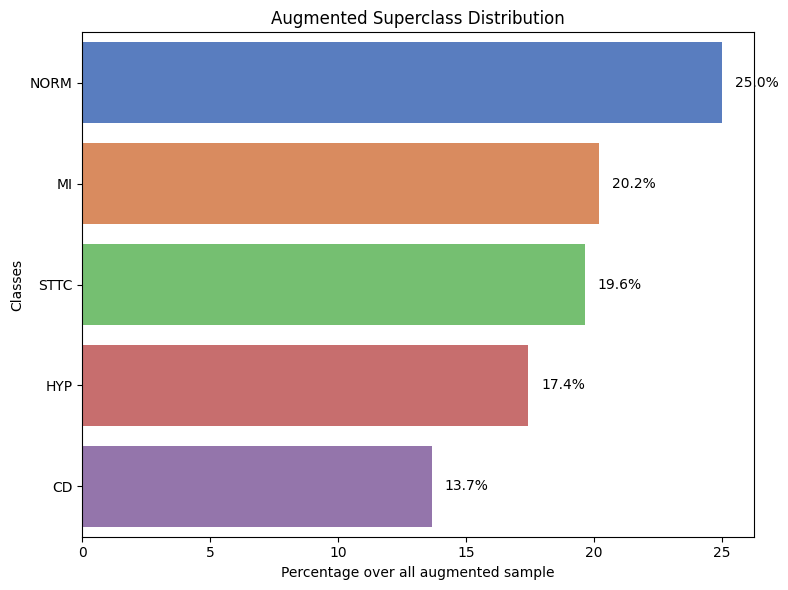

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

class_counts = np.bincount(y_train_aug)
class_counts[0] = class_counts[0]-1000

total_samples = y_train_aug.shape[0]
class_percentages = (class_counts / total_samples) * 100
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_percentages, y=classes, orient='h',ci=None, palette="muted")
plt.xlabel('Percentage over all augmented sample')
plt.ylabel('Classes')
plt.title('Augmented Superclass Distribution')

for i, v in enumerate(class_percentages):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center', ha='left')

plt.tight_layout()
plt.show()

### CNN model training with norm data 

In [10]:
# from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

#? normalizing the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

#? augmented data with swt  
X_train_aug = np.load("./artifacts/data_transformation/new_swt_Aug/X_train.npy")
y_train_aug = np.load("./artifacts/data_transformation/new_swt_Aug/y_train.npy")
X_test_aug = np.load("./artifacts/data_transformation/new_swt_Aug/X_test.npy")
y_test_aug = np.load("./artifacts/data_transformation/new_swt_Aug/y_test.npy")
X_val_aug = np.load("./artifacts/data_transformation/new_swt_Aug/X_val.npy")
y_val_aug = np.load("./artifacts/data_transformation/new_swt_Aug/y_val.npy")

print(f"size of X_train {X_train_aug.shape}, size of y_train{y_train_aug.shape}")
# print(f"size of X_test {X_test_aug.shape}, size of y_test {y_test_aug.shape}")
# print(f"size of X_val {X_val_aug.shape}, size of y_val {y_val_aug.shape}")

# scaler.fit(X_train_aug)
# X_train_aug_dl = scaler.transform(X_train_aug)
# X_test_aug_dl = scaler.transform(X_test_aug)
# X_val_aug_dl = scaler.transform(X_val_aug)
y_train_aug_dl = to_categorical(y_train_aug,num_classes=5)
y_test_aug_dl = to_categorical(y_test_aug,num_classes=5)
y_val_aug_dl = to_categorical(y_val_aug,num_classes=5)

# X_train_aug_ml = X_train_aug.reshape(-1,12000)
# y_train_aug_ml = y_train_aug
# X_val_aug_ml = X_val_aug.reshape(-1,12000)
# X_test_aug_ml = X_test_aug.reshape(-1,12000)
# y_test_aug_ml = y_test_aug
# y_val_aug_ml = y_val_aug
print(np.unique(y_train_aug,return_counts=True))

size of X_train (17957, 1000, 12), size of y_train(17957,)
(array([0, 1, 2, 3, 4], dtype=int64), array([7243, 4043, 2903, 2353, 1415], dtype=int64))


In [2]:
mean = np.mean(X_train_aug, axis=(0, 1)) 
std = np.std(X_train_aug, axis=(0, 1)) 
X_train_aug_dl = (X_train_aug - mean)/std

mean1 = np.mean(X_test_aug, axis=(0, 1)) 
std1 = np.std(X_test_aug, axis=(0, 1)) 
X_test_aug_dl = (X_test_aug - mean1)/std1

mean2 = np.mean(X_val_aug, axis=(0, 1)) 
std2 = np.std(X_val_aug, axis=(0, 1)) 
X_val_aug_dl = (X_val_aug - mean2)/std2

X_train_aug_dl.shape

NameError: name 'np' is not defined

In [4]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

def norm_model_create(input_shape, num_classes):
    model = Sequential()

    # Reduced model complexity and added L2 regularization
    model.add(Conv1D(filters=64, kernel_size=11, padding="same", input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=7, padding="same", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=5, padding="same", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(0.3))  # Reduced dropout rate

    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation="softmax"))

    return model

input_shape = (1000, 12)
num_classes = 5

norm_model = norm_model_create(input_shape, num_classes)

metrics = [
    Precision(),
    Recall(),
    AUC(multi_label=True, num_labels=num_classes),
    CategoricalAccuracy(),
    "accuracy",
    f1_m,
]

norm_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=metrics,
)

history = norm_model.fit(
    X_train_aug_dl,
    y_train_aug_dl,
    epochs=50,
    validation_data=(X_val_aug_dl, y_val_aug_dl),
    callbacks=[
        ModelCheckpoint(
            filepath="./artifacts/model_training/model/norm_model/{epoch:02d}-{val_categorical_accuracy:.2f}.keras",
            monitor="val_categorical_accuracy",
            save_best_only=True,
        ),
        TensorBoard("./artifacts/model_training/model/norm_model/logs", update_freq=1),
        # EarlyStopping(
        #     monitor="val_categorical_accuracy", patience=10, restore_best_weights=True
        # ),
    ],
)

Epoch 1/50
562/562 [==============================] - 258s 436ms/step - loss: 1.2255 - precision_1: 0.7546 - recall_1: 0.5767 - auc_1: 0.8844 - categorical_accuracy: 0.6762 - accuracy: 0.6762 - f1_m: 0.6495 - val_loss: 1.0243 - val_precision_1: 0.7688 - val_recall_1: 0.6194 - val_auc_1: 0.9008 - val_categorical_accuracy: 0.7056 - val_accuracy: 0.7056 - val_f1_m: 0.6900
Epoch 2/50
 42/562 [=>............................] - ETA: 2:53 - loss: 0.9909 - precision_1: 0.7899 - recall_1: 0.6518 - auc_1: 0.9183 - categorical_accuracy: 0.7254 - accuracy: 0.7254 - f1_m: 0.7132

KeyboardInterrupt: 

### APplying new swt 

In [83]:
import numpy as np
import pywt
import random

def swt_augmentation(ecg_signal, wavelet='db4', level=2, noise_factor=0.1, time_warp_factor=0.2, amplitude_scale_factor=0.2):
    """
    Augments an ECG signal using Stationary Wavelet Transform (SWT).
    
    Args:
        ecg_signal (numpy.ndarray): Input ECG signal.
        wavelet (str, optional): Wavelet family used for SWT decomposition.
        level (int, optional): Level of decomposition for SWT.
        noise_factor (float, optional): Factor for adding Gaussian noise to wavelet coefficients.
        time_warp_factor (float, optional): Factor for time warping wavelet coefficients.
        amplitude_scale_factor (float, optional): Factor for scaling the amplitude of wavelet coefficients.
        
    Returns:
        numpy.ndarray: Augmented ECG signal.
    """
    
    # Perform SWT decomposition
    coeffs = pywt.swtn(ecg_signal, wavelet, level)
    
    # Apply data augmentation techniques
    augmented_coeffs = []
    for coeff in coeffs:
        # Add Gaussian noise
        # coeff = coeff + random.uniform(0, noise_factor) * np.random.randn(coeff.shape)
        noise = random.uniform(0, noise_factor) * np.random.randn(len(coeff.values()),4)
        coeff = coeff.astype(np.float64) + noise.astype(np.float64)
        # coeff = coeff + random.uniform(0, noise_factor) * np.random.randn(len(coeff.values()),4)
        
        # Time warping
        time_warp_factor_rand = random.uniform(0, time_warp_factor)
        warping_indices = np.random.randint(-time_warp_factor_rand * len(coeff), time_warp_factor_rand * len(coeff), len(coeff))
        coeff = coeff[np.argsort(warping_indices)]
        
        # Amplitude scaling
        amplitude_scale_factor_rand = random.uniform(0, amplitude_scale_factor)
        coeff = coeff * (1 + amplitude_scale_factor_rand * (2 * np.random.rand() - 1))
        
        augmented_coeffs.append(coeff)
    
    # Reconstruct the augmented signal
    augmented_ecg = pywt.iswtn(augmented_coeffs, wavelet)
    
    return augmented_ecg

In [84]:
# data gene. calling swt
import random

counts = np.unique(y_train_raw, return_counts=True)[1]

augment_params = {
    "scale": random.uniform(0.8, 1.4),
    "noise": random.uniform(0.0, 0.2),
    "permute": random.choice([True, False]),
}
for i, value in enumerate(counts):
    if i == 0:
        # print("passing statemetn", i)
        continue

    aug_data_size = 3000 - value
    aug_data_size = value + aug_data_size
    # print(i, aug_data_size)
    X_temp = np.zeros(shape=(aug_data_size, 1000, 12))
    y_temp = np.zeros(shape=(aug_data_size,), dtype="int")

    y_train_index = np.where(y_train_raw == i)[0]

    for j in range(aug_data_size):
        ran_index = np.random.choice(y_train_index)
        ecg_data = X_train_raw[ran_index].T
        aug_data = swt_augmentation(ecg_data)
        # print(j)
        X_temp[j] = aug_data.T
        y_temp[j] = i
    X_train_raw = np.concatenate((X_train_raw, X_temp))
    y_train_raw = np.concatenate((y_train_raw, y_temp))

AttributeError: 'dict' object has no attribute 'astype'

### DOing preprocessing

In [15]:
import numpy as np
import pandas as pd
from scipy import signal
import pywt

# Load the raw ECG data
ecg_data = X_train_raw[0]

# Normalize each lead individually
def normalize_ecg(ecg):
    """Normalize each lead of the ECG signal using min-max scaling."""
    ecg_norm = np.zeros_like(ecg)
    for i in range(ecg.shape[1]):
        ecg_norm[:, i] = (ecg[:, i] - np.min(ecg[:, i])) / (np.max(ecg[:, i]) - np.min(ecg[:, i]))
    return ecg_norm

ecg_normalized = normalize_ecg(ecg_data)

# Denoise each lead using Butterworth filter
def denoise_ecg(ecg, cutoff=40, order=4, fs=500):
    """Apply Butterworth filter to remove noise from each lead of the ECG signal."""
    ecg_denoised = np.zeros_like(ecg)
    for i in range(ecg.shape[1]):
        nyquist = 0.5 * fs
        normalized_cutoff = cutoff / nyquist
        b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
        ecg_denoised[:, i] = signal.filtfilt(b, a, ecg[:, i])
    return ecg_denoised

ecg_denoised = denoise_ecg(ecg_normalized)

# Correct baseline using wavelet denoising
def baseline_correction(ecg, wavelet='db4', level=4):
    """Remove baseline wander from each lead of the ECG signal using wavelet denoising."""
    ecg_corrected = np.zeros_like(ecg)
    for i in range(ecg.shape[1]):
        coeffs = pywt.wavedec(ecg[:, i], wavelet, level=level)
        coeffs[-1] *= 0  # Set the approximation coefficients to zero
        ecg_corrected[:, i] = pywt.waverec(coeffs, wavelet)
    return ecg_corrected

ecg_corrected = baseline_correction(ecg_denoised)
print(ecg_corrected.shape, ecg_data.shape)


(1000, 12) (1000, 12)


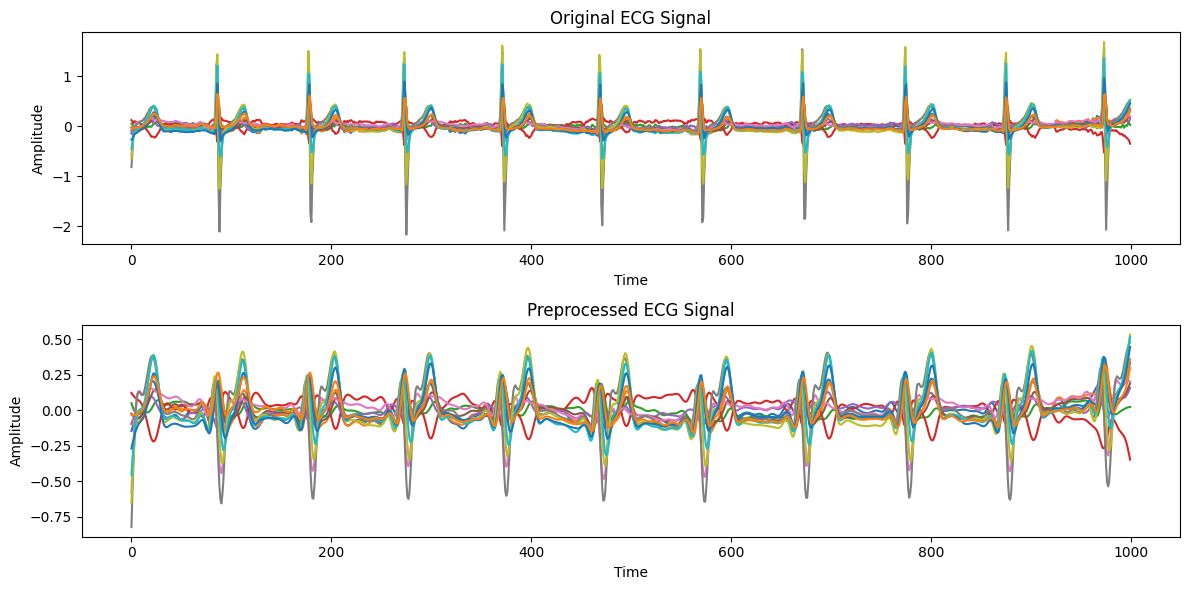

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw ECG data
ecg_data = X_test_raw[0]

# Preprocess the ECG signal
# ecg_normalized = normalize_ecg(ecg_data)
ecg_denoised = denoise_ecg(ecg_data)
ecg_corrected = baseline_correction(ecg_denoised)

# Plot the original and preprocessed ECG signals
plt.figure(figsize=(12, 6))

# Plot the original ECG signal
plt.subplot(2, 1, 1)
plt.plot(ecg_data)
plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the preprocessed ECG signal
plt.subplot(2, 1, 2)
plt.plot(ecg_corrected)
plt.title('Preprocessed ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [21]:
import seaborn as sns

<Axes: >

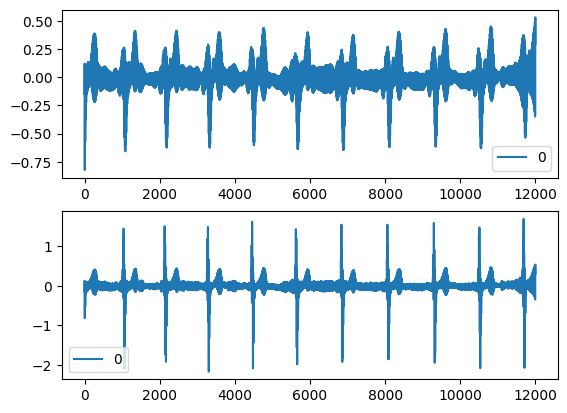

In [24]:
plt.subplot(2,1,1)
sns.lineplot(ecg_corrected.reshape(-1,1))
plt.subplot(2,1,2)
sns.lineplot(ecg_data.reshape(-1,1))


### Doing the SWT augmentation

In [29]:
X_train = X_train_raw
X_test = X_test_raw
X_val = X_val_raw
y_train = y_train_raw
y_test = y_test_raw
y_val = y_val_raw

In [30]:
np.unique(y_train_raw,return_counts=True)[1]

array([7243, 2043, 1903, 1353,  415], dtype=int64)

In [31]:
# data gene. calling swt
import random

counts = np.unique(y_train, return_counts=True)[1]

augment_params = {
    "scale": random.uniform(0.8, 1.2),
    "noise": random.uniform(0.0, 0.2),
    "permute": random.choice([True, False]),
}
for i, value in enumerate(counts):
    if i == 0:
        # print("passing statemetn", i)
        continue

    aug_data_size = 3000 - value
    aug_data_size = value + aug_data_size
    # print(i, aug_data_size)
    X_temp = np.zeros(shape=(aug_data_size, 1000, 12))
    y_temp = np.zeros(shape=(aug_data_size,), dtype="int")

    y_train_index = np.where(y_train == i)[0]

    for j in range(aug_data_size):
        ran_index = np.random.choice(y_train_index)
        ecg_data = X_train[ran_index].T
        aug_data = swt_augment(ecg_data, augment_params=augment_params)
        # print(j)
        X_temp[j] = aug_data.T
        y_temp[j] = i

    # print(
    #     "class no and original shape and new data shape", i, X_train.shape, X_temp.shape
    # )
    X_train = np.concatenate((X_train, X_temp))
    y_train = np.concatenate((y_train, y_temp))
    
print("tstet")

passing statemetn 0
1 3000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270

In [32]:
np.unique(y_train,return_counts=True),X_train.shape,y_train.shape

((array([0, 1, 2, 3, 4], dtype=int64),
  array([7243, 5043, 4903, 4353, 3415], dtype=int64)),
 (24957, 1000, 12),
 (24957,))

In [33]:
np.save("artifacts/data_transformation/new_swt_Aug1/X_train.npy", X_train)
np.save("artifacts/data_transformation/new_swt_Aug1/X_test.npy", X_test)
np.save("artifacts/data_transformation/new_swt_Aug1/X_val.npy", X_val)
np.save("artifacts/data_transformation/new_swt_Aug1/y_train.npy", y_train)
np.save("artifacts/data_transformation/new_swt_Aug1/y_test.npy", y_test)
np.save("artifacts/data_transformation/new_swt_Aug1/y_val.npy", y_val)

print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

y_train shape (24957,), X_train shape (24957, 1000, 12)
y_test shape (1650,), X_test shape (1650, 1000, 12)
y_val shape (1637,), X_val shape (1637, 1000, 12)


In [8]:
import numpy as np
import pywt

def swt_augment(data, wavelet='db4', levels=2, augment_params=None):
    """
    Augment data using Stationary Wavelet Transform (SWT).
    
    Args:
        data (numpy.ndarray): Input data of shape (num_samples, num_features).
        wavelet (str, optional): Wavelet family to use for SWT. Default is 'db4'.
        levels (int, optional): Number of decomposition levels for SWT. Default is 3.
        augment_params (dict, optional): Dictionary containing augmentation parameters.
            'scale': Scale factor for scaling wavelet coefficients.
            'noise': Standard deviation of Gaussian noise to add to wavelet coefficients.
            'permute': Boolean indicating whether to permute wavelet coefficients.
            'warping': Maximum time warping factor.
    
    Returns:
        numpy.ndarray: Augmented data of the same shape as input data.
    """
    augmented_data = []
    
    for sample in data:
        coeffs = pywt.swt(sample, wavelet, level=levels, start_level=0)
        augmented_sample = sample.copy()
        
        if augment_params is not None:
            for coeff in coeffs:
                if augment_params.get('scale', None) is not None:
                    coeff *= np.multiply(coeff, augment_params['scale'])
                if augment_params.get('noise', None) is not None:
                    coeff += np.random.normal(0, augment_params['noise'], coeff.shape)
                if augment_params.get('permute', False):
                    np.random.shuffle(coeff)
                if augment_params.get('warping', None) is not None:
                    warping_factor = np.random.uniform(-augment_params['warping'], augment_params['warping'])
                    coeff = coeff.reshape(-1)
                    coeff = np.roll(coeff, int(len(coeff) * warping_factor))
                    coeff = coeff.reshape(coeff.shape[0], -1)
            
            augmented_sample = pywt.iswt(coeffs, wavelet)
        
        augmented_data.append(augmented_sample)
    
    return np.array(augmented_data)

In [56]:
import numpy as np
import random
# from swt_augment_for_class_imbalance import swt_augment_for_class_imbalance

# Assuming your data is a numpy array of shape (1000, 12)
# data = np.random.rand(1000, 12)
# labels = np.random.randint(0, 2, size=1000)  # Binary labels (0 and 1)
data = X_train_raw[0]

# print(data.shape,.shape)
minority_class = 1  # Assuming class 1 is the minority class

augment_params = {
    'scale': random.uniform(0.8, 1.4),
    'noise': random.uniform(0.0, 0.2),
    'permute': random.choice([True, False])
}

augmented_data = swt_augment(data, augment_params=augment_params)
# print(type(augment_params['scale']))


(array([-0.03031601, -0.04594328, -0.08036368, -0.12576293, -0.14629081,
       -0.11057096, -0.06096607, -0.02204438, -0.00089318, -0.02098575,
       -0.03617025, -0.02969268]), array([-0.06995966, -0.08227895, -0.05413327,  0.01090379,  0.06080793,
        0.05599109,  0.00282787, -0.10053016, -0.10615686,  0.06972089,
        0.16661398,  0.04619334]))
(array([-0.06432529, -0.15134593, -0.1577848 , -0.01355863,  0.0859861 ,
        0.03092375, -0.03542772, -0.06201539, -0.06563678, -0.03580107,
       -0.01383442, -0.01922564]), array([ 0.02046828, -0.13296524,  0.08878323, -0.0210312 ,  0.00536913,
        0.02191341, -0.01943484, -0.00036957, -0.00245554, -0.02457733,
        0.01545707,  0.04884259]))
(array([-0.03426987, -0.0500436 , -0.08199929, -0.12375085, -0.14114009,
       -0.10496117, -0.05631852, -0.018181  ,  0.00290996, -0.01749524,
       -0.03418219, -0.03056815]), array([-0.06841826, -0.07457901, -0.05042734,  0.00550465,  0.05307888,
        0.05581459,  0.0092937

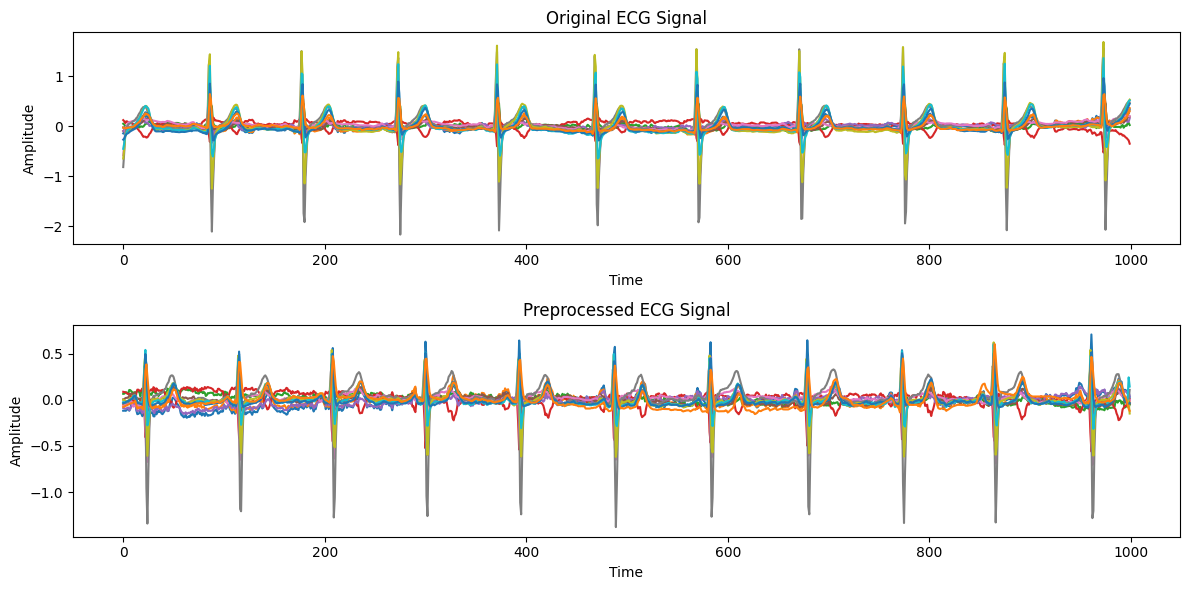

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw ECG data
ecg_data = X_test_raw[0]

# Preprocess the ECG signal
ecg_normalized = normalize_ecg(ecg_data)
ecg_denoised = denoise_ecg(ecg_data)
ecg_corrected = baseline_correction(ecg_denoised)

# Plot the original and preprocessed ECG signals
plt.figure(figsize=(12, 6))

# Plot the original ECG signal
plt.subplot(2, 1, 1)
plt.plot(ecg_data)
plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the preprocessed ECG signal
plt.subplot(2, 1, 2)
plt.plot(augmented_data)
plt.title('Preprocessed ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

<Axes: >

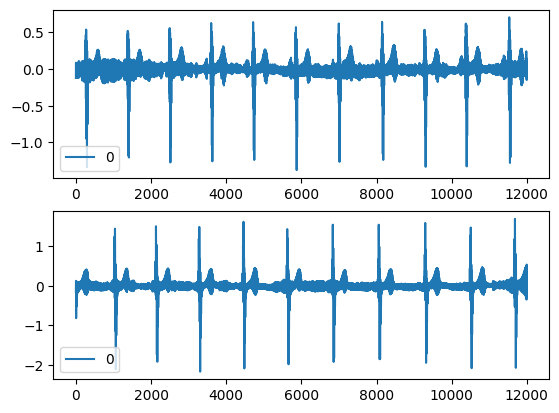

In [58]:
plt.subplot(2,1,1)
sns.lineplot(augmented_data.reshape(-1,1))
plt.subplot(2,1,2)
sns.lineplot(ecg_data.reshape(-1,1))


### Using weighting method for classification

In [47]:
#creating weights 
_,count= np.unique(y_train_raw,return_counts=True)
total = y_train_raw.shape[0]
class_1,class_2,class_3,class_4,class_5 = count

weight_class_1 = 1/(class_1/total)
weight_class_2 = 1/(class_2/total)
weight_class_3 = 1/(class_3/total)
weight_class_4 = 1/(class_4/total)
weight_class_5 = 1/(class_5/total)

weight_classes = (weight_class_1,weight_class_2,weight_class_3,weight_class_4,weight_class_5)
wei_cls = {i: v for i,v in enumerate(weight_classes)}

wei_cls

{0: 1.7888996272262874,
 1: 6.342143906020558,
 2: 6.808723068838675,
 3: 9.57649667405765,
 4: 31.221686746987952}

In [46]:
from sklearn.utils import class_weight

sklearn_wei = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train_raw),y=y_train_raw)
sklearn_wei

{0: 0.3577799254452575,
 1: 1.2684287812041115,
 2: 1.3617446137677351,
 3: 1.91529933481153,
 4: 6.244337349397591}

In [40]:
wei = {i: v for i,v in enumerate(sklearn_wei)}
wei

{0: 0.3577799254452575,
 1: 1.2684287812041115,
 2: 1.3617446137677351,
 3: 1.91529933481153,
 4: 6.244337349397591}

In [11]:
from sklearn.model_selection import cross_validate, StratifiedKFold


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
dt_model = DecisionTreeClassifier(class_weight='balanced',random_state=0)
dt_model_cv = cross_validate(dt_model,X_train_dl,y_train_raw,cv=StratifiedKFold(n_splits=5),n_jobs=-1,scoring='recall')

### Implementation ML Model with SWT Data

In [29]:
X_train_dl = X_train_raw.reshape(-1, 12000)
X_test_dl = X_test_raw.reshape(-1, 12000)

X_train_dl.shape, y_train_raw.shape, X_test_dl.shape
# xx.shape

((12957, 12000), (12957,), (1650, 12000))

In [30]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
dt_model = DecisionTreeClassifier(class_weight='balanced',random_state=0).fit(X_train_dl,y_train_raw)
# dt_model_cv = cross_validate(dt_model,X_train_dl,y_train_raw,cv=StratifiedKFold(n_splits=5),n_jobs=-1,scoring='recall')
y_dt_predict = dt_model.predict(X_test_dl)
dt_metrics = accuracy_score(y_test_raw, y_dt_predict)
# dt_auc = roc_auc_score(y_test, y_dt_predict)
dt_report = classification_report(
    y_test_raw,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)

NameError: name 'y_test' is not defined

In [31]:
print(dt_metrics)

0.42484848484848486


In [52]:
# SVM Model// not working
from sklearn import svm
model_svm = svm.SVC(kernel="rbf")
model_svm.fit(X_train_raw, y_train_raw)
y_svm_predict = model_svm.predict(X_test_dl)
svm_metrics = accuracy_score(y_test_raw, y_svm_predict)
svm_report = classification_report(y_test_raw, y_svm_predict)
print(svm_metrics)
print(svm_report)

ValueError: Found array with dim 3. SVC expected <= 2.

In [17]:
# DT CLassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(xx, y_train)
y_dt_predict = dt_model.predict(X_test)
dt_metrics = accuracy_score(y_test, y_dt_predict)
# dt_auc = roc_auc_score(y_test, y_dt_predict)
dt_report = classification_report(
    y_test,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)
# print(dt_auc)

0.2593939393939394
              precision    recall  f1-score   support

           0       0.67      0.22      0.33       912
           1       0.18      0.61      0.28       256
           2       0.16      0.14      0.15       242
           3       0.33      0.12      0.18       184
           4       0.08      0.29      0.13        56

    accuracy                           0.26      1650
   macro avg       0.28      0.28      0.21      1650
weighted avg       0.46      0.26      0.27      1650



In [41]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight=wei,solver='newton-cg',).fit(X_train_dl, y_train_raw)
y_lr_predict = model_lr.predict(X_test_dl)
lr_metric = accuracy_score(y_lr_predict, y_test_raw)
lr_report = classification_report(y_lr_predict, y_test_raw)
print(lr_metric)
print(lr_report)

0.33515151515151514
              precision    recall  f1-score   support

           0       0.46      0.57      0.51       742
           1       0.21      0.16      0.18       331
           2       0.23      0.17      0.20       315
           3       0.12      0.10      0.11       220
           4       0.05      0.07      0.06        42

    accuracy                           0.34      1650
   macro avg       0.21      0.21      0.21      1650
weighted avg       0.31      0.34      0.32      1650



In [51]:
# RF Classifier
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(
    criterion='log_loss',
    oob_score=True,
    max_features="log2",
    n_estimators=500,
    class_weight='balanced',
).fit(X_train_dl, y_train_raw)
rfc_predict = rfc_model.predict(X_test_dl)
rfc_acc = accuracy_score(rfc_predict, y_test_raw)
rfc_report = classification_report(rfc_predict, y_test_raw)
print(rfc_acc)
print(rfc_model.score(X_test_dl, y_test_raw))
print(rfc_report)

c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5563636363636364
0.5563636363636364
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      1644
           1       0.02      1.00      0.03         4
           2       0.00      0.00      0.00         0
           3       0.01      1.00      0.02         2
           4       0.00      0.00      0.00         0

    accuracy                           0.56      1650
   macro avg       0.21      0.51      0.15      1650
weighted avg       1.00      0.56      0.71      1650



In [44]:
# RF Classifier
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(

    n_estimators=10,
    class_weight=wei,
).fit(X_train_dl, y_train_raw)
rfc_predict = rfc_model.predict(X_test_dl)
rfc_acc = accuracy_score(rfc_predict, y_test_raw)
rfc_report = classification_report(rfc_predict, y_test_raw)
print(rfc_acc)
print(rfc_model.score(X_test_dl, y_test_raw))
print(rfc_report)

0.5581818181818182
0.5581818181818182
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      1492
           1       0.06      0.26      0.10        58
           2       0.06      0.23      0.10        65
           3       0.12      0.66      0.21        35
           4       0.00      0.00      0.00         0

    accuracy                           0.56      1650
   macro avg       0.24      0.35      0.23      1650
weighted avg       0.87      0.56      0.66      1650



c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ukant\anaconda3\envs\disease\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# RF Classifier
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(
    n_estimators=10,
    criterion="entropy",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=1,
    warm_start=True,
    class_weight=None,
).fit(xx, y_train)
rfc_predict = rfc_model.predict(X_test)
rfc_acc = accuracy_score(rfc_predict, y_test)
rfc_report = classification_report(rfc_predict, y_test)
print(rfc_acc)
print(rfc_model.score(X_test, y_test))
print(rfc_report)

In [19]:
# RF Classifier
from sklearn.ensemble import RandomForestClassifier

# ??
# !! run the extended CNN and LSTM with SWT data model 
# **

rfc_model = RandomForestClassifier(
    n_estimators=10,
    criterion="entropy",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=1,
    warm_start=True,
    class_weight=None,
).fit(xx, y_train)
rfc_predict = rfc_model.predict(X_test)
rfc_acc = accuracy_score(rfc_predict, y_test)
rfc_report = classification_report(rfc_predict, y_test)
print(rfc_acc)
print(rfc_model.score(X_test, y_test))
print(rfc_report)

0.5133333333333333
0.5133333333333333
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1129
           1       0.21      0.23      0.22       227
           2       0.21      0.26      0.23       192
           3       0.17      0.38      0.24        85
           4       0.04      0.12      0.05        17

    accuracy                           0.51      1650
   macro avg       0.28      0.32      0.29      1650
weighted avg       0.59      0.51      0.55      1650



### DL MOdel With SWT data

In [22]:
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Bidirectional
import pandas as pd
from tensorflow.keras.metrics import Precision, Recall, AUC, CategoricalAccuracy, F1Score


In [15]:
# transforming data for DL
from tensorflow.keras.utils import to_categorical

y_train_dl = to_categorical(y_train_raw, num_classes=5)
y_test_dl = to_categorical(y_test_raw, num_classes=5)
y_val_dl = to_categorical(y_val_raw, num_classes=5)
print(y_train_raw.shape, y_test_raw.shape, y_val_raw.shape)
# y_train_dl.shape, y_test_dl.shape, y_val_dl.shape, X_train.shape

(12957,) (1650,) (1637,)


In [7]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([5743, 6043, 5903, 5353, 4415], dtype=int64))

In [27]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation="relu", input_shape=(1000, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 996, 64)           3904      
                                                                 
 max_pooling1d (MaxPooling1  (None, 498, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 494, 128)          41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 247, 128)          0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 31616)             0         
                                                                 
 dense (Dense)               (None, 128)              

In [25]:
from keras.regularizers import l2
import tensorflow as tf
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation="LeakyReLU", input_shape=(1000, 12), kernel_regularizer=l2(0.03)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation="LeakyReLU", kernel_regularizer=l2(0.04)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation="LeakyReLU", kernel_regularizer=l2(0.04)))
model.add(Dropout(0.3))

model.add(Dense(5, activation="softmax", kernel_regularizer=l2(0.04)))

# model.summary()
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        "Precision",
        "Recall",
        F1Score(average='macro'),
        CategoricalAccuracy(),
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        ),
    ],
)

model.fit(X_train_raw, y_train_dl, epochs=10, batch_size=200, validation_data=(X_val_raw,y_val_dl))

MemoryError: Unable to allocate 593. MiB for an array with shape (12957, 1000, 12) and data type float32

In [4]:
model02 = Sequential()
model02.add(Conv1D(128, 55, activation="relu", input_shape=(1000, 12)))
# model02.add(MaxPooling1D(10))
model02.add(Dropout(0.5))
model02.add(Conv1D(128, 25, activation="relu"))
model02.add(MaxPooling1D(5))
model02.add(Dropout(0.5))
model02.add(Conv1D(128, 10, activation="relu"))
# model02.add(MaxPooling1D(5))
# model02.add(Dropout(0.5))
# model02.add(Conv1D(128, 5, activation='relu'))
model02.add(GlobalAveragePooling1D())
model02.add(Flatten())
model02.add(Dense(256, kernel_initializer="normal", activation="relu"))
model02.add(Dropout(0.5))
model02.add(Dense(128, kernel_initializer="normal", activation="relu"))
model02.add(Dropout(0.5))
model02.add(Dense(64, kernel_initializer="normal", activation="relu"))
model02.add(Dropout(0.5))
model02.add(Dense(5,
            kernel_initializer="normal", activation="softmax"))
model02.summary()
model02.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        "Precision",
        "Recall",
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        ),
    ],
)
model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=200, validation_data=(X_val_dl,y_val_dl))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 946, 128)          84608     
                                                                 
 dropout_5 (Dropout)         (None, 946, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 922, 128)          409728    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 184, 128)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 184, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 175, 128)          163968    
                                                      

NameError: name 'tf' is not defined

In [30]:
import tensorflow as tf
MODEL_CHECKPOINT = ""
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_CHECKPOINT, monitor="val_binary_accuracy", save_best_only=True
    ),
]
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        "Precision",
        "Recall",
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        ),
    ],
)
history = model.fit(
    X_train,
    y_train_dl,
    epochs=10,
    batch_size=100,
    callbacks=callbacks_list,
    validation_data=(X_val, y_val_dl),
)


# history = model.fit(X_train, y_train, epochs=10, batch_size=100,)
# test_loss , test_accuracy = model.evaluate(X_test,y_test_encoded)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")
# model01 = tf.keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/10
155/155 [==============================] - 33s 199ms/step - loss: 1.0560 - accuracy: 0.5980 - precision: 0.7598 - recall: 0.3803 - AUC: 0.8500 - val_loss: 0.9604 - val_accuracy: 0.6347 - val_precision: 0.7330 - val_recall: 0.5064 - val_AUC: 0.8554
Epoch 2/10
155/155 [==============================] - 33s 216ms/step - loss: 0.6629 - accuracy: 0.7649 - precision: 0.8309 - recall: 0.6816 - AUC: 0.9393 - val_loss: 0.8876 - val_accuracy: 0.6940 - val_precision: 0.7462 - val_recall: 0.6286 - val_AUC: 0.8466
Epoch 3/10
155/155 [==============================] - 33s 210ms/step - loss: 0.4435 - accuracy: 0.8455 - precision: 0.8819 - recall: 0.8016 - AUC: 0.9701 - val_loss: 0.9808 - val_accuracy: 0.6830 - val_precision: 0.7170 - val_recall: 0.6378 - val_AUC: 0.8422
Epoch 4/10
155/155 [==============================] - 34s 219ms/step - loss: 0.3091 - accuracy: 0.8944 - precision: 0.9168 - recall: 0.8656 - AUC: 0.9847 - val_loss: 1.0130 - val_accuracy: 0.6768 - val_precision: 0.7162 - v

In [ ]:
modelodel = Sequential()
model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
model.add(Dropout(0.2))
model.add(Normalization.BatchNormalization())
model.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.2))
model.add(Normalization.BatchNormalization())
model.add(Dense(dimout, activation='sigmoid'))
adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
weights = np.array([64.0, 0.1,])
model.compile(loss=categorical_crossentropy, #loss=weighted_categorical_crossentropy(weights), 
                  optimizer='adam', 
                  metrics=['categorical_accuracy', ]) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
print(model.summary())

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

input_shape = (1000, 12)  
output_shape = 5

model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(output_shape, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# X_train = X_train.reshape((-1, 1000, 12))  # Reshape input data to (samples, time_steps, features)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=output_shape)  # One-hot encode the output

model.fit(X_train, y_train_dl, epochs=10, batch_size=200, validation_split=0.2)

Epoch 1/10
  5/110 [>.............................] - ETA: 15:32 - loss: 1.6021 - accuracy: 0.2510

KeyboardInterrupt: 

In [7]:
X_trainx = X_train.reshape((-1, 1000, 12))  # Reshape input data to (samples, time_steps, features)
X_trainx.shape

(27457, 1000, 12)

### Generating Data with SWT func

In [6]:
X_train = X_train_raw
X_test = X_test_raw
X_val = X_val_raw
y_train = y_train_raw
y_test = y_test_raw
y_val = y_val_raw

In [7]:
value, counts = np.unique(y_train, return_counts=True)
_, index = np.unique(
    y_train,
    return_counts=True,
)
value, counts

(array([0, 1, 2, 3, 4], dtype=int64),
 array([7243, 2043, 1903, 1353,  415], dtype=int64))

In [8]:
y_1_indi = np.where(y_train == 0)[0]
# Assuming you want to drop 1000 samples where y_train is 0
num_samples_to_drop = 1500
print(X_train.shape, y_train.shape)

# Randomly select 1000 indices from zero_indices
drop_indices = np.random.choice(y_1_indi, size=num_samples_to_drop, replace=False)

# Create a boolean mask to keep the remaining samples
keep_mask = np.ones(X_train.shape[0], dtype=bool)
keep_mask[drop_indices] = False

# Filter X_train and y_train using the keep_mask
X_train = X_train[keep_mask]
y_train = y_train[keep_mask]
X_train.shape, y_train.shape

(12957, 1000, 12) (12957,)


((11457, 1000, 12), (11457,))

In [52]:
# SWT fucn
import numpy as np
import pywt


def SWT_filter(
    s: np.ndarray,
    wavelet_family: str = "db",
    level: int = None,
    padding: str = "symmetric",
    coefficient_manipulation: str = None,
    normalize: bool = False,
) -> np.ndarray:
    """
    Stationary wavelet transform augmentation
    :param s: one lead signal
    :param wavelet_family: wavelet family (e.g., 'db', 'coif', 'sym')
    :param level: decomposition level (if None, use maximum possible level)
    :param padding: padding strategy ('symmetric', 'zero', 'periodic')
    :param coefficient_manipulation: strategy for modifying wavelet coefficients (e.g., 'drop_high_freq', 'randomize')
    :param normalize: whether to normalize the augmented signal
    :return: preprocessed data
    """
    # Input validation
    if not isinstance(s, np.ndarray):
        raise TypeError("Input signal 's' must be a NumPy array.")
    if not isinstance(wavelet_family, str):
        raise TypeError("Input 'wavelet_family' must be a string.")
    if not isinstance(level, int) and level is not None:
        raise ValueError("Input 'level' must be an integer or None.")
    if padding not in ["symmetric", "zero", "periodic"]:
        raise ValueError(
            "Invalid padding strategy. Choose from 'symmetric', 'zero', or 'periodic'."
        )

    # Determine the maximum possible decomposition level
    max_level = pywt.swt_max_level(len(s))

    # If level is not provided, use the maximum possible level
    level = level if level is not None else max_level

    # Select the wavelet based on the provided family
    wavelet = pywt.wavelist(wavelet_family)[0]

    # Pad the signal
    original_length = len(s)
    pad_width = 0
    if len(s) % 2 != 0:
        pad_width = 1

    if padding == "symmetric":
        s_padded = np.pad(s, pad_width=pad_width, mode="symmetric")
    elif padding == "zero":
        s_padded = np.pad(s, pad_width=pad_width, mode="constant", constant_values=0)
    else:  # periodic
        s_padded = np.pad(s, pad_width=pad_width, mode="wrap")

    # Calculate the wavelet coefficients
    coeffs = pywt.swt(s_padded, wavelet, level=level, trim_approx=True, norm=True)

    # Apply coefficient manipulation strategy
    if coefficient_manipulation == "drop_high_freq":
        # Drop high-frequency coefficients
        coeffs[level:] = [np.zeros_like(c) for c in coeffs[level:]]
    elif coefficient_manipulation == "randomize":
        # Randomize a subset of coefficients
        num_coeffs = len(coeffs)
        indices_to_randomize = np.random.choice(
            num_coeffs, size=num_coeffs // 4, replace=False
        )
        for idx in indices_to_randomize:
            coeffs[idx] = np.random.normal(0, 1, size=coeffs[idx].shape)

    # Reconstruct the signal
    augmented_signal = pywt.iswt(coeffs, wavelet, norm=True)

    # Remove padding and restore original signal length
    augmented_signal = augmented_signal[pad_width : pad_width + original_length]

    # Normalize the augmented signal if specified
    if normalize:
        augmented_signal = (
            augmented_signal - augmented_signal.mean()
        ) / augmented_signal.std()
    return augmented_signal.T

In [12]:
# test
print(counts[1])
aug_data_size = 4000 - counts[1]
print(aug_data_size)
aug_data_size = counts[1] + aug_data_size
print(aug_data_size)

2043
1957
4000


In [44]:
import numpy as np
from scipy.signal import resample

def time_warp_augment(ecg_signal, warp_factor=0.08):
    """
    Augment ECG signal by applying time warping.
    
    Args:
        ecg_signal (np.ndarray): ECG signal with shape (1000, 12)
        warp_factor (float): Warping factor to control the amount of stretching or compression
        
    Returns:
        np.ndarray: Augmented ECG signal with the same shape
    """
    # Generate a warping factor for each lead
    warping_factors = np.random.uniform(low=1-warp_factor, high=1+warp_factor, size=(12,))
    
    # Apply time warping to each lead
    warped_signal = np.zeros_like(ecg_signal)
    for i in range(12):
        lead_signal = ecg_signal[:, i]
        warped_lead = resample(lead_signal, int(len(lead_signal) * warping_factors[i]))
        warped_lead = resample(warped_lead, 1000)  # Resample to original length
        warped_signal[:, i] = warped_lead
        
    return warped_signal

In [47]:
# lead permutation func
def lead_permutation_augment(ecg_signal):
    """
    Augment ECG signal by permuting the order of leads.
    
    Args:
        ecg_signal (np.ndarray): ECG signal with shape (1000, 12)
        
    Returns:
        np.ndarray: Augmented ECG signal with the same shape
    """
    # Generate a random permutation of the leads
    permutation = np.random.permutation(12)
    
    # Permute the leads
    permuted_signal = ecg_signal[:, permutation]
    
    return permuted_signal

(1000, 12) (1000, 12)


C:\Users\Ukant\AppData\Local\Temp\ipykernel_11464\2994535451.py:15: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(new_data,palette= sns.color_palette("husl"))


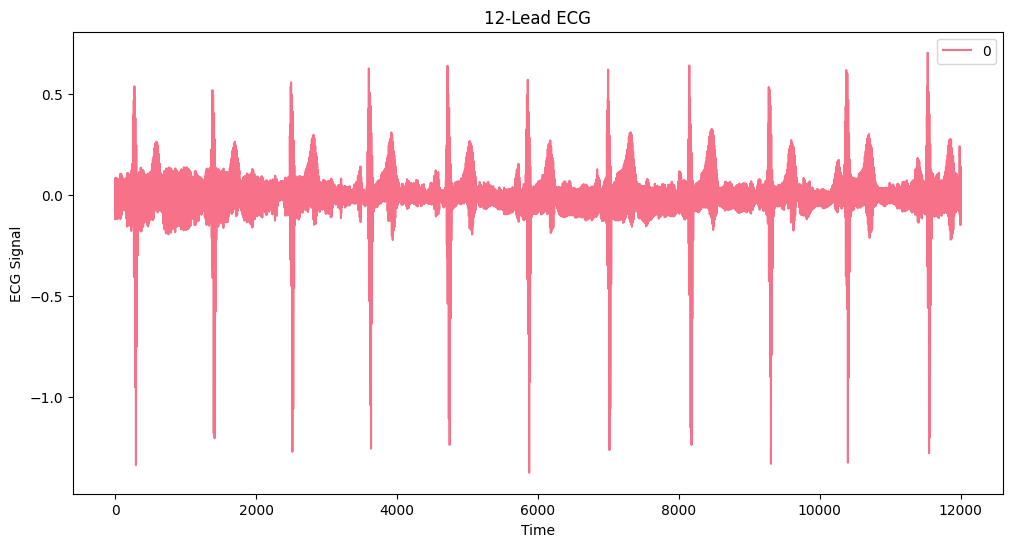

In [59]:
import matplotlib.pyplot as plt 
import seaborn as sns
# augdata = lead_permutation_augment(X_train[0])
augdata = SWT_filter(X_train[110],level=2)
augdata  = augdata.T
print(augdata.shape,X_train_raw[110].shape)
augdata = augdata.reshape(-1, 1)  
new_data = X_train_raw[0].reshape(-1,1)
# Create a time axis
time_axis = np.arange(augdata.shape[0])

# Plot the ECG data as a line graph
plt.figure(figsize=(12, 6))
# sns.lineplot( augdata)
sns.lineplot(new_data,palette= sns.color_palette("husl"))
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.title('12-Lead ECG')
plt.show()

In [8]:
# data gene. calling swt
import itertools

wavelet_families = ["db", "coif", "sym"]
levels = [1, 2, 3]
cofficient_manipulatios = ["drop_high_freq", "randomize"]

params = list(itertools.product(wavelet_families, levels, cofficient_manipulatios))
print(params)
for i, value in enumerate(counts):
    if i == 0:
        print("passing statemetn", i)
        continue

    aug_data_size = 4000 - value
    aug_data_size = value + aug_data_size
    print(i, aug_data_size)
    X_temp = np.zeros(shape=(aug_data_size, 1000, 12))
    y_temp = np.zeros(shape=(aug_data_size,), dtype="int")

    y_train_index = np.where(y_train == i)[0]

    for j in range(aug_data_size):
        ran_index = np.random.choice(y_train_index)
        ecg_data = X_train[ran_index].T
        wavelet_family, level, cofficient_manipulation = params[
            np.random.randint(len(params))
        ]
        aug_data = SWT_filter(
            ecg_data,
            coefficient_manipulation=cofficient_manipulation,
            level=level,
            wavelet_family=wavelet_family,
        )
        X_temp[j] = aug_data
        y_temp[j] = i

    print(
        "class no and original shape and new data shape", i, X_train.shape, X_temp.shape
    )
    X_train = np.concatenate((X_train, X_temp))
    y_train = np.concatenate((y_train, y_temp))

[('db', 1, 'drop_high_freq'), ('db', 1, 'randomize'), ('db', 2, 'drop_high_freq'), ('db', 2, 'randomize'), ('db', 3, 'drop_high_freq'), ('db', 3, 'randomize'), ('coif', 1, 'drop_high_freq'), ('coif', 1, 'randomize'), ('coif', 2, 'drop_high_freq'), ('coif', 2, 'randomize'), ('coif', 3, 'drop_high_freq'), ('coif', 3, 'randomize'), ('sym', 1, 'drop_high_freq'), ('sym', 1, 'randomize'), ('sym', 2, 'drop_high_freq'), ('sym', 2, 'randomize'), ('sym', 3, 'drop_high_freq'), ('sym', 3, 'randomize')]
passing statemetn 0
1 4000


NameError: name 'SWT_filter' is not defined

In [14]:
print(
    f"y_train shape {y_train.shape}, X_train shape {X_train.shape} class balance is {np.unique(y_train,return_counts=True)}"
)
print(
    f"y_test shape {y_test.shape}, X_test shape {X_test.shape} class balance is {np.unique(y_test,return_counts=True)}"
)
print(
    f"y_val shape {y_val.shape}, X_val shape {X_val.shape} class balance is {np.unique(y_val,return_counts=True)}"
)

y_train shape (27457,), X_train shape (27457, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([5743, 6043, 5903, 5353, 4415], dtype=int64))
y_test shape (1650,), X_test shape (1650, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([912, 256, 242, 184,  56], dtype=int64))
y_val shape (1637,), X_val shape (1637, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([914, 233, 255, 171,  64], dtype=int64))


In [15]:
print(
    f"y_train shape {y_train.shape}, X_train shape {X_train.shape} class balance is {np.unique(y_train,return_counts=True)}"
)
print(
    f"y_test shape {y_test.shape}, X_test shape {X_test.shape} class balance is {np.unique(y_test,return_counts=True)}"
)
print(
    f"y_val shape {y_val.shape}, X_val shape {X_val.shape} class balance is {np.unique(y_val,return_counts=True)}"
)


y_train shape (27457,), X_train shape (27457, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([5743, 6043, 5903, 5353, 4415], dtype=int64))
y_test shape (1650,), X_test shape (1650, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([912, 256, 242, 184,  56], dtype=int64))
y_val shape (1637,), X_val shape (1637, 1000, 12) class balance is (array([0, 1, 2, 3, 4], dtype=int64), array([914, 233, 255, 171,  64], dtype=int64))


In [16]:
np.save("artifacts/data_transformation/swt_Aug_data1/X_train.npy", X_train)
np.save("artifacts/data_transformation/swt_Aug_data1/X_test.npy", X_test)
np.save("artifacts/data_transformation/swt_Aug_data1/X_val.npy", X_val)
np.save("artifacts/data_transformation/swt_Aug_data1/y_train.npy", y_train)
np.save("artifacts/data_transformation/swt_Aug_data1/y_test.npy", y_test)
np.save("artifacts/data_transformation/swt_Aug_data1/y_val.npy", y_val)

print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

y_train shape (27457,), X_train shape (27457, 1000, 12)
y_test shape (1650,), X_test shape (1650, 1000, 12)
y_val shape (1637,), X_val shape (1637, 1000, 12)


In [12]:
%pwd

'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram\\research'

In [13]:
from pyflowchart import Flowchart
with open('swtfunc.py') as f:
    code = f.read()

fc = Flowchart.from_code(code)
print(fc.flowchart())

op2=>operation: import numpy as np
op4=>operation: import pywt
st7=>start: start SWT_filter
io9=>inputoutput: input: s, wavelet_family, level, padding, coefficient_manipulation, normalize
op12=>operation: "\n    Stationary wavelet transform augmentation\n    :param s: one lead signal\n    :param wavelet_family: wavelet family (e.g., 'db', 'coif', 'sym')\n    :param level: decomposition level (if None, use maximum possible level)\n    :param padding: padding strategy ('symmetric', 'zero', 'periodic')\n    :param coefficient_manipulation: strategy for modifying wavelet coefficients (e.g., 'drop_high_freq', 'randomize')\n    :param normalize: whether to normalize the augmented signal\n    :return: preprocessed data\n    "
cond15=>operation: raise TypeError("Input signal 's' must be a NumPy array.") if  (not isinstance(s, np.ndarray))
cond26=>operation: raise TypeError("Input 'wavelet_family' must be a string.") if  (not isinstance(wavelet_family, str))
cond37=>operation: raise ValueError(

In [ ]:
# Algo data-Aug generation
for i, val in enumerate(y_train[:55]):
    if val == 0:
        aug_no = 2000 - count[1]

        for i in range(aug_no):
            x_i = X_train[i].T

            aug_data = SWT_filter(x_i)

            yy = np.append(yy, aug_data)
            print(aug_data)

        print("11", i + 1)

        print("pass")

    elif val == 1:
        # aug_no = count[1]

        print("pass", i)

    elif val == 2:
        aug_no = 2000 - count[2]

        for i in range(aug_no):
            x_i = X_train[i].T

            aug_data = SWT_filter(x_i)

            yy = np.append(yy, aug_data)
            print(aug_data)

        print("22", i + 1)

    elif val == 3:
        aug_no = 2000 - count[3]

        for i in range(aug_no):
            x_i = X_train[i].T

            aug_data = SWT_filter(x_i)

            yy = np.append(yy, aug_data)

            print(aug_data.shape)

        print("33", i + 1)

    elif val == 4:
        aug_no = 2000 - count[4]

        for i in range(aug_no):
            x_i = X_train[i].T

            aug_data = SWT_filter(x_i)

            yy = np.append(yy, aug_data)
            print(aug_data)

        print("44", i + 1)

    else:
        print("y no ", y_train[i])
yy

### COmparing Generated data with SWT FUnc

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

KeyboardInterrupt: 

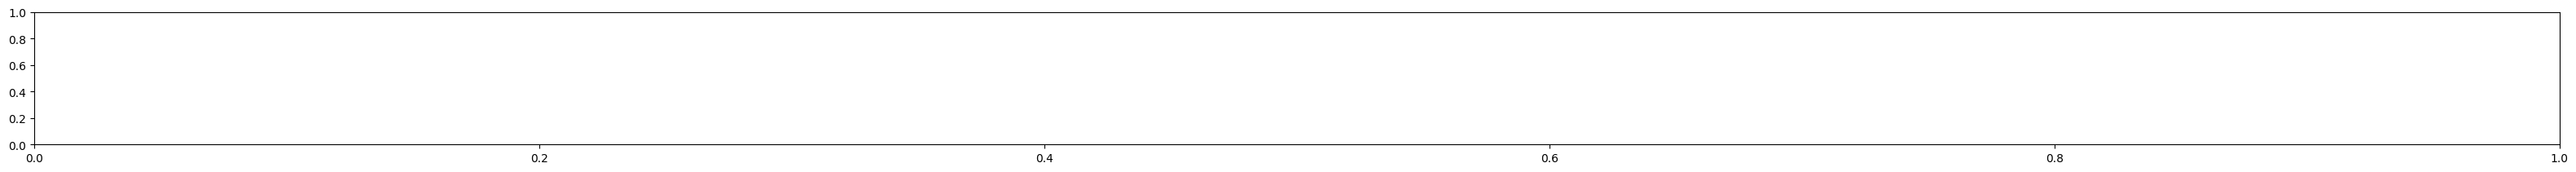

In [16]:
sample = X[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(40, 30))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.show()

In [15]:
# aug_no = 2000 - count[3]
# for i in range(3):
#     x_i = X_train[i].T
#     aug_data = SWT_filter(x_i)
#     print(x_i.shape,aug_data.shape)
#     # aug_data = aug_data.T
import numpy as np
# yy = np.append(yy,aug_data)

x_i = X_test[0].T
aug_data = SWT_filter(x_i, level=3, padding="periodic",coefficient_manipulation='drop_high_freq')
print(x_i.shape, aug_data.shape)

# Assuming you have the input signal 's' and the augmented signal 'augmented_signal'
s = X_test[0]
augmented_signal = aug_data
# Calculate statistical properties for the input signal
input_mean = np.mean(s)
input_std = np.std(s)
# input_skew = np.skew(s)
# input_kurt = np.kurtosis(s)?
input_energy = np.sum(s**2)
input_peak_to_peak = np.ptp(s)

# Calculate statistical properties for the augmented signal
aug_mean = np.mean(augmented_signal)
aug_std = np.std(augmented_signal)
# aug_skew = np.skew(augmented_signal)
# aug_kurt = np.kurtosis(augmented_signal)
aug_energy = np.sum(augmented_signal**2)
aug_peak_to_peak = np.ptp(augmented_signal)

# Print the statistical properties for comparison
print("Statistical Properties:")
print(f"Mean: Input={input_mean:.4f}, Augmented={aug_mean:.4f}")
print(f"Standard Deviation: Input={input_std:.4f}, Augmented={aug_std:.4f}")
# print(f'Skewness: Input={input_skew:.4f}, Augmented={aug_skew:.4f}')
# print(f'Kurtosis: Input={input_kurt:.4f}, Augmented={aug_kurt:.4f}')
print(f"Signal Energy: Input={input_energy:.4f}, Augmented={aug_energy:.4f}")
print(
    f"Peak-to-Peak Amplitude: Input={input_peak_to_peak:.4f}, Augmented={aug_peak_to_peak:.4f}"
)

(12, 1000) (1000, 12)
Statistical Properties:
Mean: Input=-0.0015, Augmented=-0.0015
Standard Deviation: Input=0.1771, Augmented=0.1549
Signal Energy: Input=376.2444, Augmented=288.0700
Peak-to-Peak Amplitude: Input=3.8520, Augmented=2.8088


Text(0.5, 1.0, 'aug data')

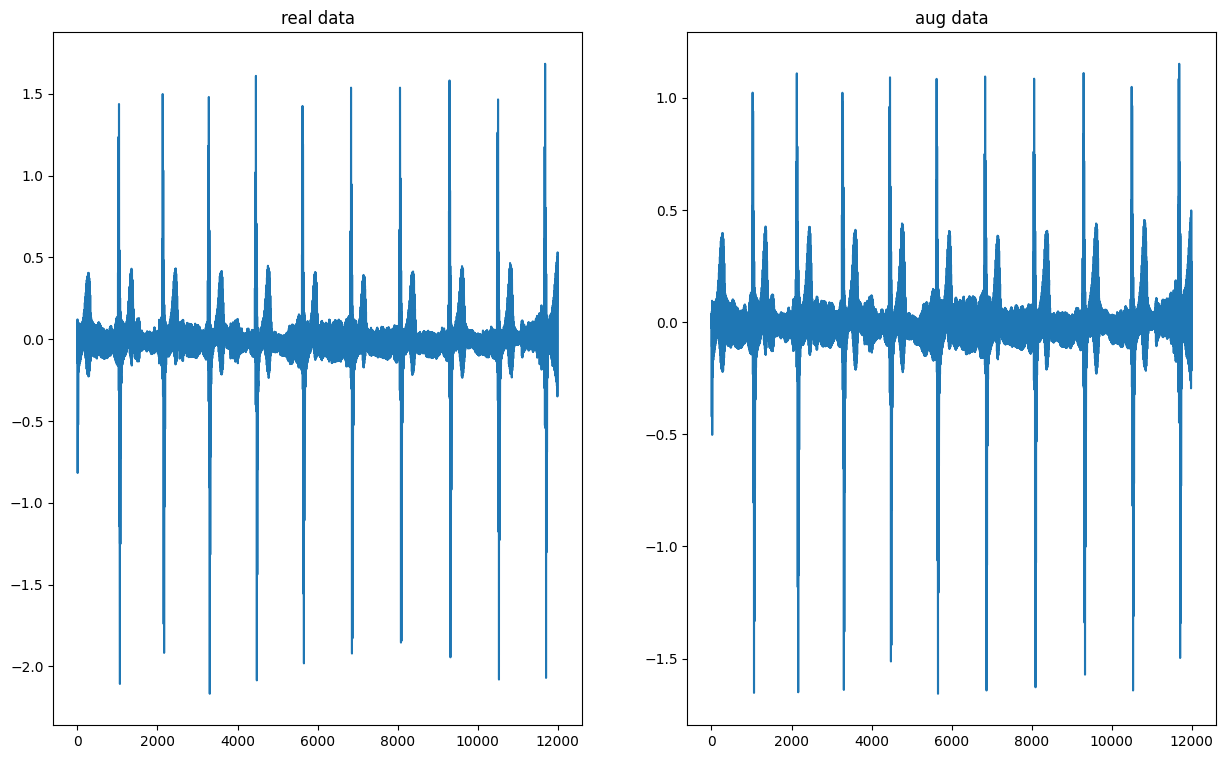

In [16]:
plt.figure(figsize=(15, 9))
plt.subplot(1, 2, 1)
plt.plot(X_test[0].flatten())
plt.title("real data")


plt.subplot(1, 2, 2)
plt.plot(aug_data.flatten())
plt.title("aug data")

In [29]:
import numpy as np

# Assuming you have the input signal 's' and the augmented signal 'augmented_signal'
s = X_train[0]
augmented_signal = aug_data
# Calculate statistical properties for the input signal
input_mean = np.mean(s)
input_std = np.std(s)
# input_skew = np.skew(s)
# input_kurt = np.kurtosis(s)?
input_energy = np.sum(s**2)
input_peak_to_peak = np.ptp(s)

# Calculate statistical properties for the augmented signal
aug_mean = np.mean(augmented_signal)
aug_std = np.std(augmented_signal)
# aug_skew = np.skew(augmented_signal)
# aug_kurt = np.kurtosis(augmented_signal)
aug_energy = np.sum(augmented_signal**2)
aug_peak_to_peak = np.ptp(augmented_signal)

# Print the statistical properties for comparison
print("Statistical Properties:")
print(f"Mean: Input={input_mean:.4f}, Augmented={aug_mean:.4f}")
print(f"Standard Deviation: Input={input_std:.4f}, Augmented={aug_std:.4f}")
# print(f'Skewness: Input={input_skew:.4f}, Augmented={aug_skew:.4f}')
# print(f'Kurtosis: Input={input_kurt:.4f}, Augmented={aug_kurt:.4f}')
print(f"Signal Energy: Input={input_energy:.4f}, Augmented={aug_energy:.4f}")
print(
    f"Peak-to-Peak Amplitude: Input={input_peak_to_peak:.4f}, Augmented={aug_peak_to_peak:.4f}"
)

Statistical Properties:
Mean: Input=0.0001, Augmented=0.0001
Standard Deviation: Input=0.1076, Augmented=0.1076
Signal Energy: Input=139.0225, Augmented=139.0225
Peak-to-Peak Amplitude: Input=2.0830, Augmented=2.0830


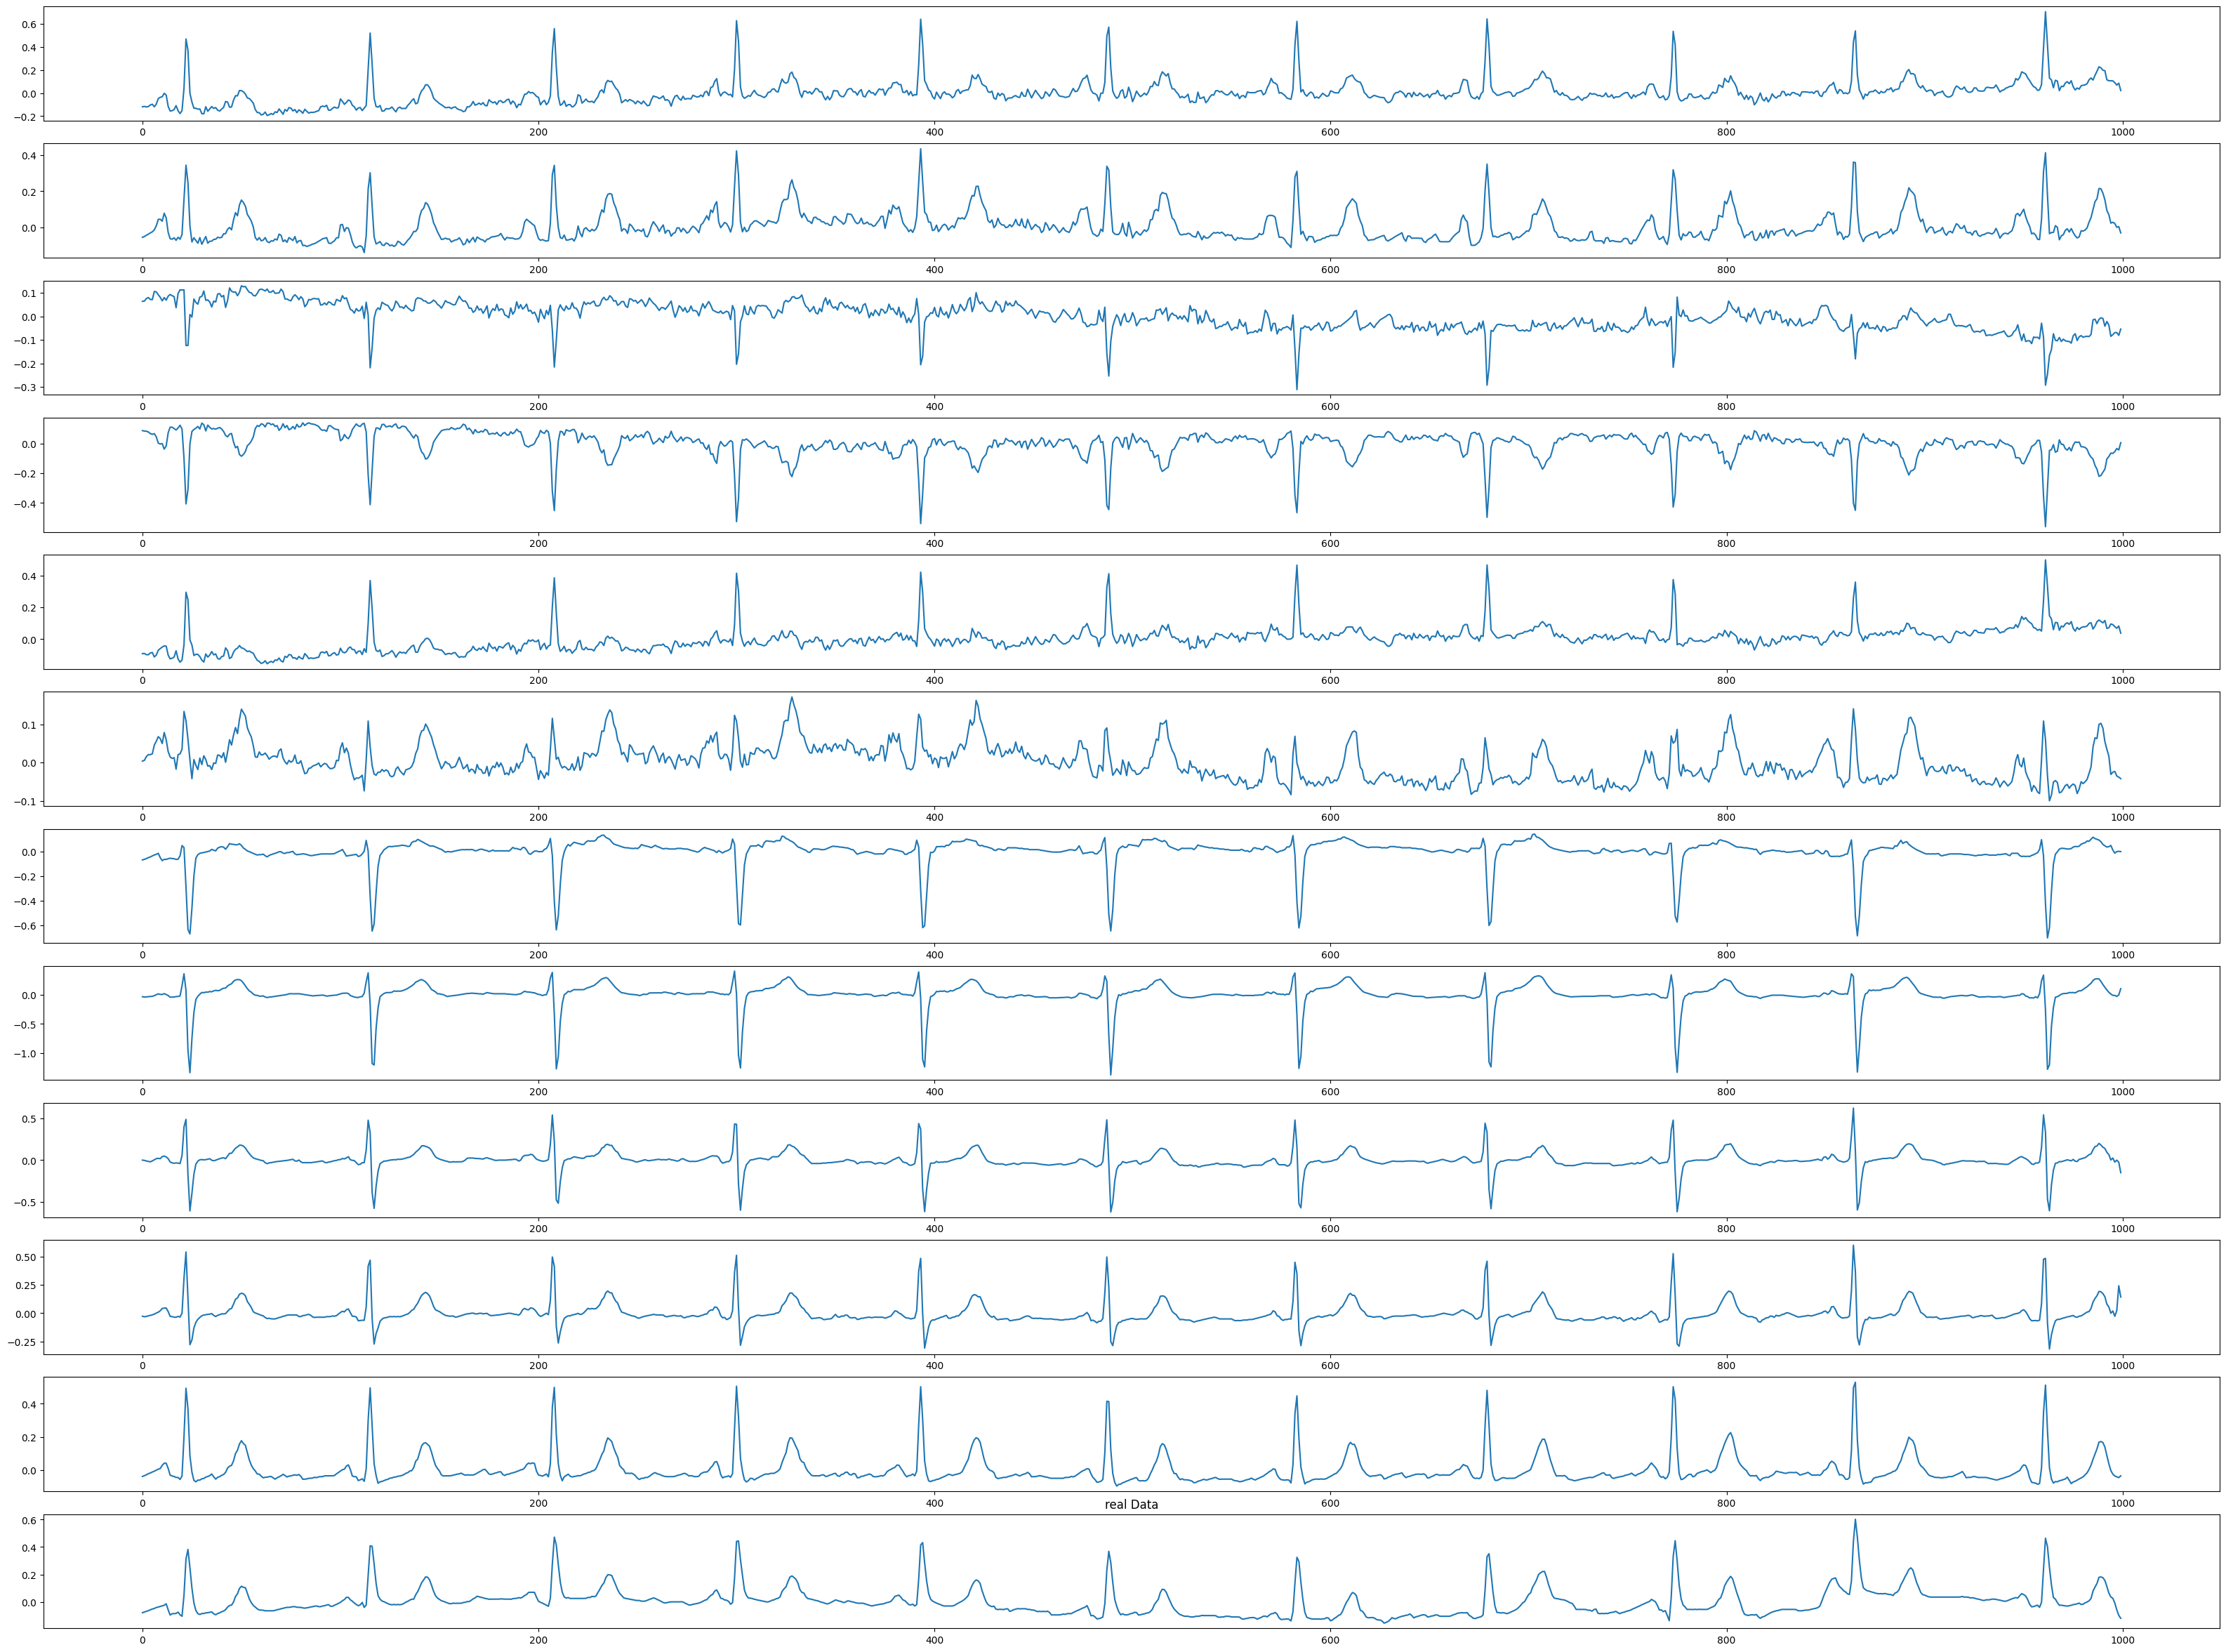

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sample = X_train[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(40, 30))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.title("real Data")
plt.show()

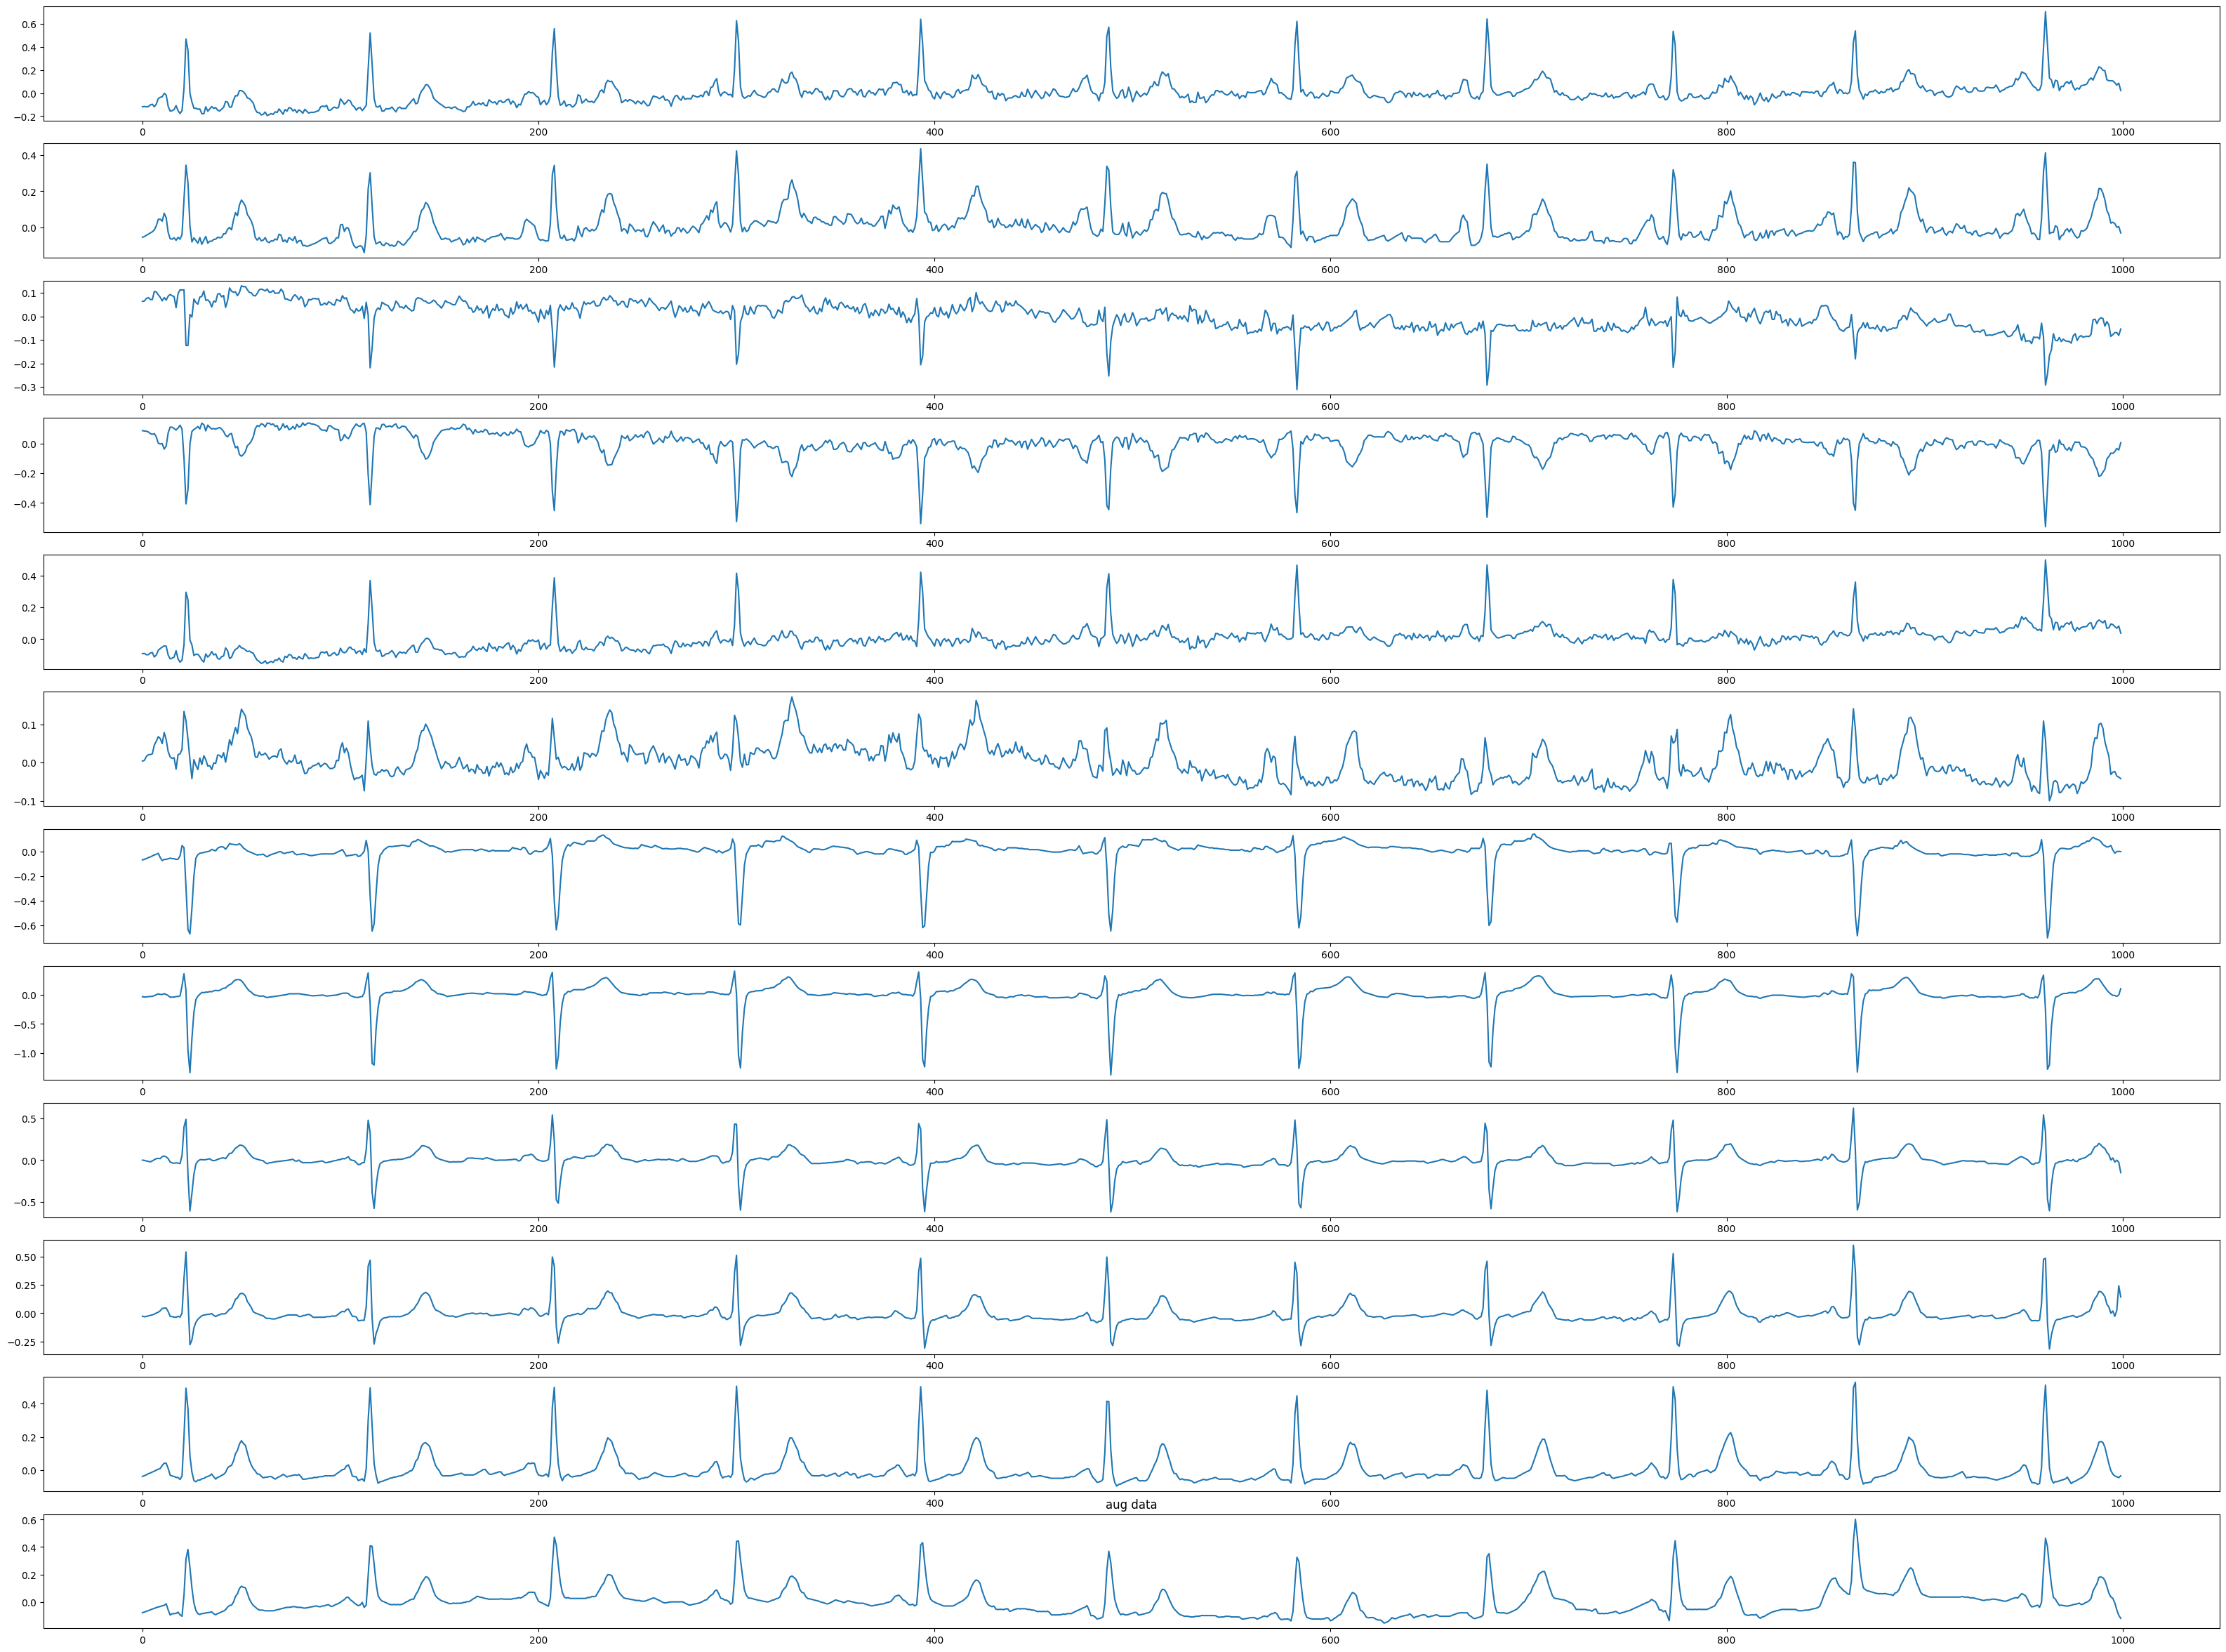

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sample = aug_data
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(40, 30))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.title("aug data")
plt.show()

In [22]:
np.save("ml_model/X_train.npy", X_train)
np.save("ml_model/X_test.npy", X_test)
np.save("ml_model/X_val.npy", X_val)
np.save("ml_model/y_train.npy", y_train)
np.save("ml_model/y_test.npy", y_test)
np.save("ml_model/y_val.npy", y_val)

print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

y_train shape (12957,), X_train shape (12957, 12)
y_test shape (1650,), X_test shape (1650, 12)
y_val shape (1637,), X_val shape (1637, 12)


### withDWT transform

In [31]:
%pip install PyWavelets
# %pip install ecglib


  Using cached pywavelets-1.5.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
Using cached pywavelets-1.5.0-cp311-cp311-win_amd64.whl (4.3 MB)


### SMOTE for oversampling

In [27]:
%pip install imblearn

  Using cached imbalanced_learn-0.12.0-py3-none-any.whl.metadata (8.2 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.0-py3-none-any.whl (257 kB)
Note: you may need to restart the kernel to use updated packages.


In [28]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

In [64]:
X_filtered.shape, Y_filtered_np.shape

((16244, 1000, 12), (16244,))

In [35]:
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

In [44]:
np.unique(y_train_oversampled, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([7243, 7243, 7243, 7243, 7243], dtype=int64))

In [36]:
print(X_train.shape, y_train.shape)
print(X_train_oversampled.shape, y_train_oversampled.shape)

(12957, 12) (12957,)
(36215, 12) (36215,)


In [15]:
# import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

In [50]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(
    X_train_oversampled, y_train_oversampled
)
y_dt_predict = dt_model.predict(X_test)
dt_metrics = accuracy_score(y_test, y_dt_predict)
# dt_auc = roc_auc_score(y_train_oversampled, y_dt_predict)
dt_report = classification_report(
    y_test,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)
# print(dt_auc)

0.0703030303030303
              precision    recall  f1-score   support

           0       0.58      0.05      0.09       912
           1       0.17      0.04      0.06       256
           2       0.12      0.06      0.08       242
           3       0.08      0.04      0.05       184
           4       0.03      0.77      0.06        56

    accuracy                           0.07      1650
   macro avg       0.20      0.19      0.07      1650
weighted avg       0.38      0.07      0.08      1650



In [52]:
from sklearn import svm


model_svm = svm.SVC(kernel="rbf")

model_svm.fit(X_train_oversampled, y_train_oversampled)

y_dt_predict = dt_model.predict(X_test)

dt_metrics = accuracy_score(y_test, y_dt_predict)

# dt_auc = roc_auc_score(y_train_oversampled, y_dt_predict)

dt_report = classification_report(
    y_test,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)

# print(dt_auc)

0.0703030303030303
              precision    recall  f1-score   support

           0       0.58      0.05      0.09       912
           1       0.17      0.04      0.06       256
           2       0.12      0.06      0.08       242
           3       0.08      0.04      0.05       184
           4       0.03      0.77      0.06        56

    accuracy                           0.07      1650
   macro avg       0.20      0.19      0.07      1650
weighted avg       0.38      0.07      0.08      1650



In [55]:
cc, (len0, len1, len2, len3, len4) = np.unique(y_train, return_counts=True)
cc, len0, len1, len2, len3, len4

(array([0, 1, 2, 3, 4], dtype=int64), 7243, 2043, 1903, 1353, 415)

### Downsampling the dataset

In [12]:
class_counts = np.array([7243, 2043, 1903, 1353, 415])
target_class_counts = np.unique(y_train, return_counts=True)[1]

if not np.array_equal(class_counts, target_class_counts):
    raise ValueError("Class counts in X and y do not match.")

downsampled_indices = []

for count, label in enumerate(np.unique(y_train)):
    class_indices = np.where(y_train == label)[0]
    if len(class_indices) > 500:
        downsampled_indices.extend(
            np.random.choice(class_indices, size=500, replace=False)
        )
    else:
        downsampled_indices.extend(class_indices)

downsampled_X = X_train[downsampled_indices]
downsampled_y = y_train[downsampled_indices]
downsampled_X.shape, downsampled_y.shape

((2415, 12), (2415,))

In [60]:
np.unique(downsampled_y, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([500, 500, 500, 500, 415], dtype=int64))

In [16]:
from sklearn import svm


model_svm = svm.SVC(kernel="rbf")

model_svm.fit(downsampled_X, downsampled_y)

y_dt_predict = model_svm.predict(X_test)

dt_metrics = accuracy_score(y_test, y_dt_predict)

# dt_auc = roc_auc_score(y_train_oversampled, y_dt_predict)

dt_report = classification_report(
    y_test,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)

# print(dt_auc)

0.1987878787878788
              precision    recall  f1-score   support

           0       0.55      0.13      0.21       912
           1       0.22      0.15      0.18       256
           2       0.15      0.46      0.23       242
           3       0.12      0.34      0.18       184
           4       0.00      0.00      0.00        56

    accuracy                           0.20      1650
   macro avg       0.21      0.22      0.16      1650
weighted avg       0.37      0.20      0.20      1650



In [17]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=5).fit(
    downsampled_X, downsampled_y
)
y_dt_predict = dt_model.predict(X_test)
dt_metrics = accuracy_score(y_test, y_dt_predict)
# dt_auc = roc_auc_score(y_train_oversampled, y_dt_predict)
dt_report = classification_report(
    y_test,
    y_dt_predict,
)
print(dt_metrics)
print(dt_report)
# print(dt_auc)

0.4127272727272727
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       912
           1       0.07      0.00      0.01       256
           2       0.15      0.24      0.19       242
           3       0.11      0.10      0.11       184
           4       0.00      0.00      0.00        56

    accuracy                           0.41      1650
   macro avg       0.18      0.20      0.18      1650
weighted avg       0.36      0.41      0.38      1650

